# Exercise Performance Analysis using Data Mining Techniques


## Abstract
Strength Training techniques have been used in tailored routines during personalized training programs for athletes. During recent times, there has been a shift from tried and tested to evidence-based training routines. But with more advancement in the field of ML and IOT, more companies like HUDL, LongoMatch are leveraging this domain to gain more insights into the field of sports and we think this will be the same in the field of Strength Training.

In future, we think the ML model and a human expert will work together to make decisions productively for realistic short-term goal to long-term fruition. We intend to use historical work out data to gain insights about how to efficiently one can plan his future workout sessions. In our current project we discuss the current data gathering techniques used by athletes, processing methods for this data to be used in the model and proof-of-concept system for strength training based on Progressive Overload.

> Key-Words: Strength Training, Progressive Overload, Hypertrophy, proof-of-concept, Volume, Repetitions, Sets, Trend Analysis 


## Challenges

1. Small Data size
2. Summarizing the information against different levels of granuality.
3. Handling of missing value.




# One Click Setup | Imports | Load datasets

In [3]:
import gc
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import set_config
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,explained_variance_score
import warnings
warnings.filterwarnings('ignore')

# For use in google collab
# from google.colab import drive,files
# drive.mount('/content/gdrive')

# Google collab dir: Account: kikarand@iu.edu
# DATA_DIR = "gdrive/MyDrive/data/"

# Local storage
DATA_DIR = "data"


def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    display(df.describe())
    display(df.isna().sum())
    return df

# lets store the datasets in a dictionary so we can keep track of them easily
datasets={}  
ds_names = ("notes_exported",)

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)
	  

for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')
	
	
glog = datasets["notes_exported"]

notes_exported: shape is (11176, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           11176 non-null  object 
 1   Exercise       11176 non-null  object 
 2   Category       11176 non-null  object 
 3   Weight (kgs)   9998 non-null   float64
 4   Reps           10921 non-null  float64
 5   Distance       132 non-null    float64
 6   Distance Unit  132 non-null    object 
 7   Time           290 non-null    object 
 8   Comment        522 non-null    object 
dtypes: float64(3), object(6)
memory usage: 785.9+ KB
None


Date                   Exercise Category  Weight (kgs)  Reps  \
0  2019-09-12  Seated Calf Raise Machine    Calfs          20.0  17.0   
1  2019-09-12  Seated Calf Raise Machine    Calfs          20.0  17.0   
2  2019-09-12  Seated Calf Raise Machine    Calfs          20.0  15.0   
3  2019-09-12          Romanian Deadlift     Legs          25.0   8.0   
4  2019-09-12          Romanian Deadlift     Legs          25.0   8.0   

   Distance Distance Unit Time Comment  
0       NaN           NaN  NaN     NaN  
1       NaN           NaN  NaN     NaN  
2       NaN           NaN  NaN     NaN  
3       NaN           NaN  NaN     NaN  
4       NaN           NaN  NaN     NaN

Weight (kgs)          Reps    Distance
count   9998.000000  10921.000000  132.000000
mean      29.546209     13.713122    3.160606
std       24.603065     56.077269    2.007047
min        0.000000      0.000000    0.460000
25%       12.500000      8.000000    1.535000
50%       25.000000     10.000000    2.505000
75%       40.000000     13.000000    4.500000
max      200.000000   2500.000000   12.300000

Date                 0
Exercise             0
Category             0
Weight (kgs)      1178
Reps               255
Distance         11044
Distance Unit    11044
Time             10886
Comment          10654
dtype: int64

dataset notes_exported          : [     11,176, 9]


## Data Pre processing

In [ ]:
glog["Date"].head(10)

0    2019-09-12
1    2019-09-12
2    2019-09-12
3    2019-09-12
4    2019-09-12
5    2019-09-12
6    2019-09-12
7    2019-09-12
8    2019-09-12
9    2019-09-12
Name: Date, dtype: object

In [ ]:
glog["Date"] = glog["Date"].astype("datetime64")


In [ ]:
glog[~glog.Time.isna()].Time.head(10)

21     0:15:00
40     0:20:00
63     0:17:00
147    0:15:00
166    0:00:20
167    0:00:20
168    0:00:20
191    0:11:00
213    0:21:00
260    0:10:00
Name: Time, dtype: object

In [ ]:
glog["Volume"] = glog["Weight (kgs)"] * glog["Reps"]

In [ ]:
glog.rename(columns={"Weight (kgs)": "Weight"}, inplace=True)

In [ ]:
glog["duration"] = pd.to_datetime(glog[~glog.Time.isna()].Time, format="%H:%M:%S").apply(lambda x: int((x.hour*60) + x.minute + (x.second/60)))
glog[["Time", "duration"]].fillna(0, inplace=True)

In [ ]:
by_date_cat = glog.set_index(["Date", "Category"])
by_cat_date = glog.set_index(["Category", "Date"])

In [ ]:
glog.head(10)

Date                   Exercise Category  Weight  Reps  Distance  \
0 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  17.0       NaN   
1 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  17.0       NaN   
2 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  15.0       NaN   
3 2019-09-12          Romanian Deadlift     Legs    25.0   8.0       NaN   
4 2019-09-12          Romanian Deadlift     Legs    25.0   8.0       NaN   
5 2019-09-12          Romanian Deadlift     Legs    30.0  24.0       NaN   
6 2019-09-12  Neutral Grip Lat Pulldown     Back    55.0   8.0       NaN   
7 2019-09-12  Neutral Grip Lat Pulldown     Back    55.0   8.0       NaN   
8 2019-09-12  Neutral Grip Lat Pulldown     Back    65.0  16.0       NaN   
9 2019-09-12              Barbell Shrug     Back    10.0  15.0       NaN   

  Distance Unit Time     Comment  Volume  duration  
0           NaN  NaN         NaN   340.0       NaN  
1           NaN  NaN         NaN   340.0       NaN  
2           NaN  NaN         NaN   300.0       NaN  
3           NaN  NaN         NaN   200.0       NaN  
4           NaN  NaN         NaN   200.0       NaN  
5           NaN  NaN  Rest pause   720.0       NaN  
6           NaN  NaN         NaN   440.0       NaN  
7           NaN  NaN         NaN   440.0       NaN  
8           NaN  NaN         NaN  1040.0       NaN  
9           NaN  NaN         NaN   150.0       NaN

In [ ]:
by_date_cat.head(10)

Exercise  Weight  Reps  Distance  \
Date       Category                                                      
2019-09-12 Calfs     Seated Calf Raise Machine    20.0  17.0       NaN   
           Calfs     Seated Calf Raise Machine    20.0  17.0       NaN   
           Calfs     Seated Calf Raise Machine    20.0  15.0       NaN   
           Legs              Romanian Deadlift    25.0   8.0       NaN   
           Legs              Romanian Deadlift    25.0   8.0       NaN   
           Legs              Romanian Deadlift    30.0  24.0       NaN   
           Back      Neutral Grip Lat Pulldown    55.0   8.0       NaN   
           Back      Neutral Grip Lat Pulldown    55.0   8.0       NaN   
           Back      Neutral Grip Lat Pulldown    65.0  16.0       NaN   
           Back                  Barbell Shrug    10.0  15.0       NaN   

                    Distance Unit Time     Comment  Volume  duration  
Date       Category                                                   
2019-09-12 Calfs              NaN  NaN         NaN   340.0       NaN  
           Calfs              NaN  NaN         NaN   340.0       NaN  
           Calfs              NaN  NaN         NaN   300.0       NaN  
           Legs               NaN  NaN         NaN   200.0       NaN  
           Legs               NaN  NaN         NaN   200.0       NaN  
           Legs               NaN  NaN  Rest pause   720.0       NaN  
           Back               NaN  NaN         NaN   440.0       NaN  
           Back               NaN  NaN         NaN   440.0       NaN  
           Back               NaN  NaN         NaN  1040.0       NaN  
           Back               NaN  NaN         NaN   150.0       NaN

In [ ]:
by_cat_date.head(10)

Exercise  Weight  Reps  Distance  \
Category Date                                                            
Calfs    2019-09-12  Seated Calf Raise Machine    20.0  17.0       NaN   
         2019-09-12  Seated Calf Raise Machine    20.0  17.0       NaN   
         2019-09-12  Seated Calf Raise Machine    20.0  15.0       NaN   
Legs     2019-09-12          Romanian Deadlift    25.0   8.0       NaN   
         2019-09-12          Romanian Deadlift    25.0   8.0       NaN   
         2019-09-12          Romanian Deadlift    30.0  24.0       NaN   
Back     2019-09-12  Neutral Grip Lat Pulldown    55.0   8.0       NaN   
         2019-09-12  Neutral Grip Lat Pulldown    55.0   8.0       NaN   
         2019-09-12  Neutral Grip Lat Pulldown    65.0  16.0       NaN   
         2019-09-12              Barbell Shrug    10.0  15.0       NaN   

                    Distance Unit Time     Comment  Volume  duration  
Category Date                                                         
Calfs    2019-09-12           NaN  NaN         NaN   340.0       NaN  
         2019-09-12           NaN  NaN         NaN   340.0       NaN  
         2019-09-12           NaN  NaN         NaN   300.0       NaN  
Legs     2019-09-12           NaN  NaN         NaN   200.0       NaN  
         2019-09-12           NaN  NaN         NaN   200.0       NaN  
         2019-09-12           NaN  NaN  Rest pause   720.0       NaN  
Back     2019-09-12           NaN  NaN         NaN   440.0       NaN  
         2019-09-12           NaN  NaN         NaN   440.0       NaN  
         2019-09-12           NaN  NaN         NaN  1040.0       NaN  
         2019-09-12           NaN  NaN         NaN   150.0       NaN

## Exploratory Data Analysis

### Summary of Training Log

In [ ]:
glog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           11176 non-null  datetime64[ns]
 1   Exercise       11176 non-null  object        
 2   Category       11176 non-null  object        
 3   Weight         9998 non-null   float64       
 4   Reps           10921 non-null  float64       
 5   Distance       132 non-null    float64       
 6   Distance Unit  132 non-null    object        
 7   Time           290 non-null    object        
 8   Comment        522 non-null    object        
 9   Volume         9998 non-null   float64       
 10  duration       290 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 960.6+ KB


In [ ]:
glog.describe()

Weight          Reps    Distance       Volume    duration
count  9998.000000  10921.000000  132.000000  9998.000000  290.000000
mean     29.546209     13.713122    3.160606   299.981326   18.827586
std      24.603065     56.077269    2.007047   272.793092   20.775400
min       0.000000      0.000000    0.460000     0.000000    0.000000
25%      12.500000      8.000000    1.535000   132.000000    0.000000
50%      25.000000     10.000000    2.505000   240.000000   11.000000
75%      40.000000     13.000000    4.500000   390.000000   35.000000
max     200.000000   2500.000000   12.300000  3120.000000   75.000000

In [ ]:
glog.describe(include="all")

Date                Exercise Category       Weight  \
count                 11176                   11176    11176  9998.000000   
unique                  529                     150       13          NaN   
top     2020-03-27 00:00:00  Lateral Dumbbell Raise     Back          NaN   
freq                     47                     403     2158          NaN   
first   2019-09-12 00:00:00                     NaN      NaN          NaN   
last    2022-03-04 00:00:00                     NaN      NaN          NaN   
mean                    NaN                     NaN      NaN    29.546209   
std                     NaN                     NaN      NaN    24.603065   
min                     NaN                     NaN      NaN     0.000000   
25%                     NaN                     NaN      NaN    12.500000   
50%                     NaN                     NaN      NaN    25.000000   
75%                     NaN                     NaN      NaN    40.000000   
max                     NaN                     NaN      NaN   200.000000   

                Reps    Distance Distance Unit     Time Comment       Volume  \
count   10921.000000  132.000000           132      290     522  9998.000000   
unique           NaN         NaN             3       66     294          NaN   
top              NaN         NaN            km  0:00:30  Drop 1          NaN   
freq             NaN         NaN           110       36      19          NaN   
first            NaN         NaN           NaN      NaN     NaN          NaN   
last             NaN         NaN           NaN      NaN     NaN          NaN   
mean       13.713122    3.160606           NaN      NaN     NaN   299.981326   
std        56.077269    2.007047           NaN      NaN     NaN   272.793092   
min         0.000000    0.460000           NaN      NaN     NaN     0.000000   
25%         8.000000    1.535000           NaN      NaN     NaN   132.000000   
50%        10.000000    2.505000           NaN      NaN     NaN   240.000000   
75%        13.000000    4.500000           NaN      NaN     NaN   390.000000   
max      2500.000000   12.300000           NaN      NaN     NaN  3120.000000   

          duration  
count   290.000000  
unique         NaN  
top            NaN  
freq           NaN  
first          NaN  
last           NaN  
mean     18.827586  
std      20.775400  
min       0.000000  
25%       0.000000  
50%      11.000000  
75%      35.000000  
max      75.000000

In [ ]:
glog.head(10)

Date                   Exercise Category  Weight  Reps  Distance  \
0 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  17.0       NaN   
1 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  17.0       NaN   
2 2019-09-12  Seated Calf Raise Machine    Calfs    20.0  15.0       NaN   
3 2019-09-12          Romanian Deadlift     Legs    25.0   8.0       NaN   
4 2019-09-12          Romanian Deadlift     Legs    25.0   8.0       NaN   
5 2019-09-12          Romanian Deadlift     Legs    30.0  24.0       NaN   
6 2019-09-12  Neutral Grip Lat Pulldown     Back    55.0   8.0       NaN   
7 2019-09-12  Neutral Grip Lat Pulldown     Back    55.0   8.0       NaN   
8 2019-09-12  Neutral Grip Lat Pulldown     Back    65.0  16.0       NaN   
9 2019-09-12              Barbell Shrug     Back    10.0  15.0       NaN   

  Distance Unit Time     Comment  Volume  duration  
0           NaN  NaN         NaN   340.0       NaN  
1           NaN  NaN         NaN   340.0       NaN  
2           NaN  NaN         NaN   300.0       NaN  
3           NaN  NaN         NaN   200.0       NaN  
4           NaN  NaN         NaN   200.0       NaN  
5           NaN  NaN  Rest pause   720.0       NaN  
6           NaN  NaN         NaN   440.0       NaN  
7           NaN  NaN         NaN   440.0       NaN  
8           NaN  NaN         NaN  1040.0       NaN  
9           NaN  NaN         NaN   150.0       NaN

In [ ]:
glog.index

RangeIndex(start=0, stop=11176, step=1)

In [ ]:
glog

Date                   Exercise Category  Weight   Reps  Distance  \
0     2019-09-12  Seated Calf Raise Machine    Calfs    20.0   17.0       NaN   
1     2019-09-12  Seated Calf Raise Machine    Calfs    20.0   17.0       NaN   
2     2019-09-12  Seated Calf Raise Machine    Calfs    20.0   15.0       NaN   
3     2019-09-12          Romanian Deadlift     Legs    25.0    8.0       NaN   
4     2019-09-12          Romanian Deadlift     Legs    25.0    8.0       NaN   
...          ...                        ...      ...     ...    ...       ...   
11171 2022-03-03             Back Extension     Back     NaN    7.0       NaN   
11172 2022-03-03             Back Extension     Back     NaN    7.0       NaN   
11173 2022-03-03             Back Extension     Back     NaN    7.0       NaN   
11174 2022-03-04               Stair Master   Cardio     NaN  204.0       NaN   
11175 2022-03-04                  Treadmill   Cardio     NaN    NaN      0.76   

      Distance Unit     Time Comment  Volume  duration  
0               NaN      NaN     NaN   340.0       NaN  
1               NaN      NaN     NaN   340.0       NaN  
2               NaN      NaN     NaN   300.0       NaN  
3               NaN      NaN     NaN   200.0       NaN  
4               NaN      NaN     NaN   200.0       NaN  
...             ...      ...     ...     ...       ...  
11171           NaN      NaN     NaN     NaN       NaN  
11172           NaN      NaN     NaN     NaN       NaN  
11173           NaN      NaN     NaN     NaN       NaN  
11174           NaN  0:50:00     NaN     NaN      50.0  
11175            mi  0:15:00     NaN     NaN      15.0  

[11176 rows x 11 columns]

In [ ]:
glog.isna().sum()

Date                 0
Exercise             0
Category             0
Weight            1178
Reps               255
Distance         11044
Distance Unit    11044
Time             10886
Comment          10654
Volume            1178
duration         10886
dtype: int64

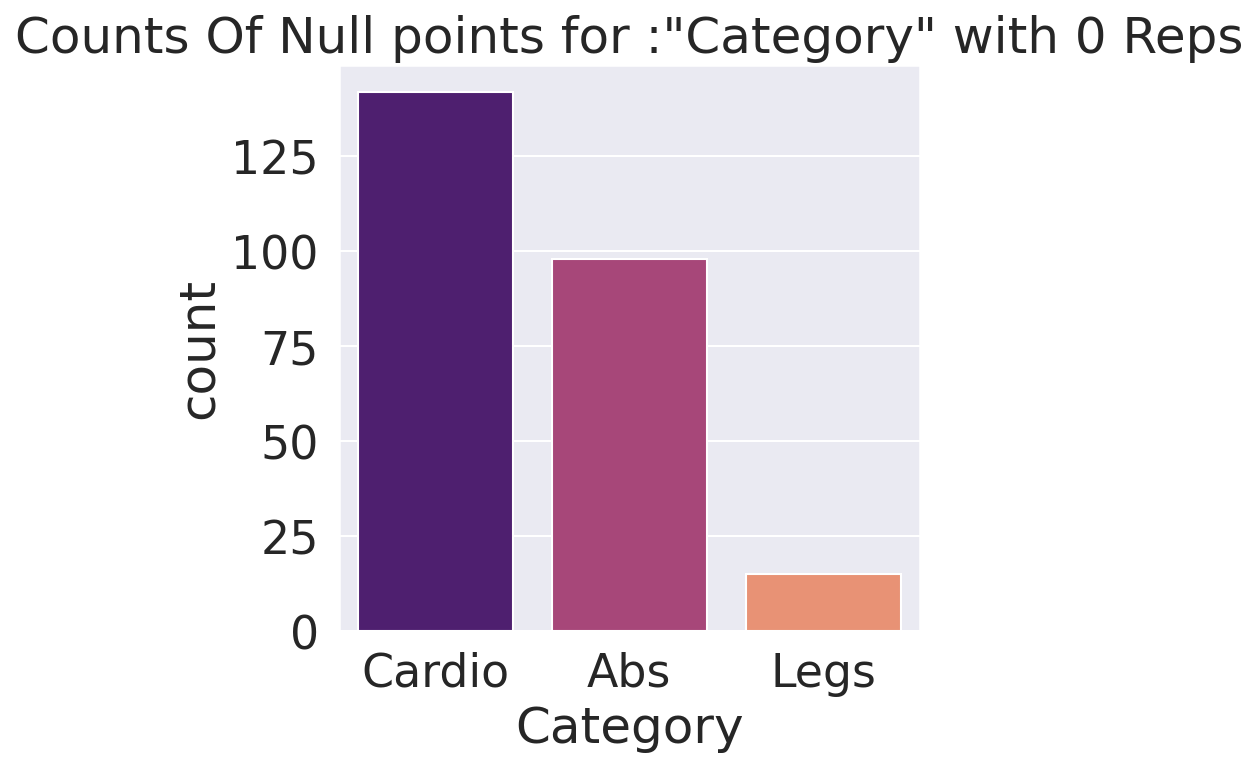

In [ ]:
fig, ax =  plt.subplots(1,1, figsize=(5,5), dpi=150)
sns.set_style("darkgrid")
sns.countplot("Category", data=glog[glog.Reps.isna()].reset_index(),ax=ax, palette ="magma")
ax.set_title('Counts Of Null points for :"Category" with 0 Reps');


Text(0, 0.5, 'Count')

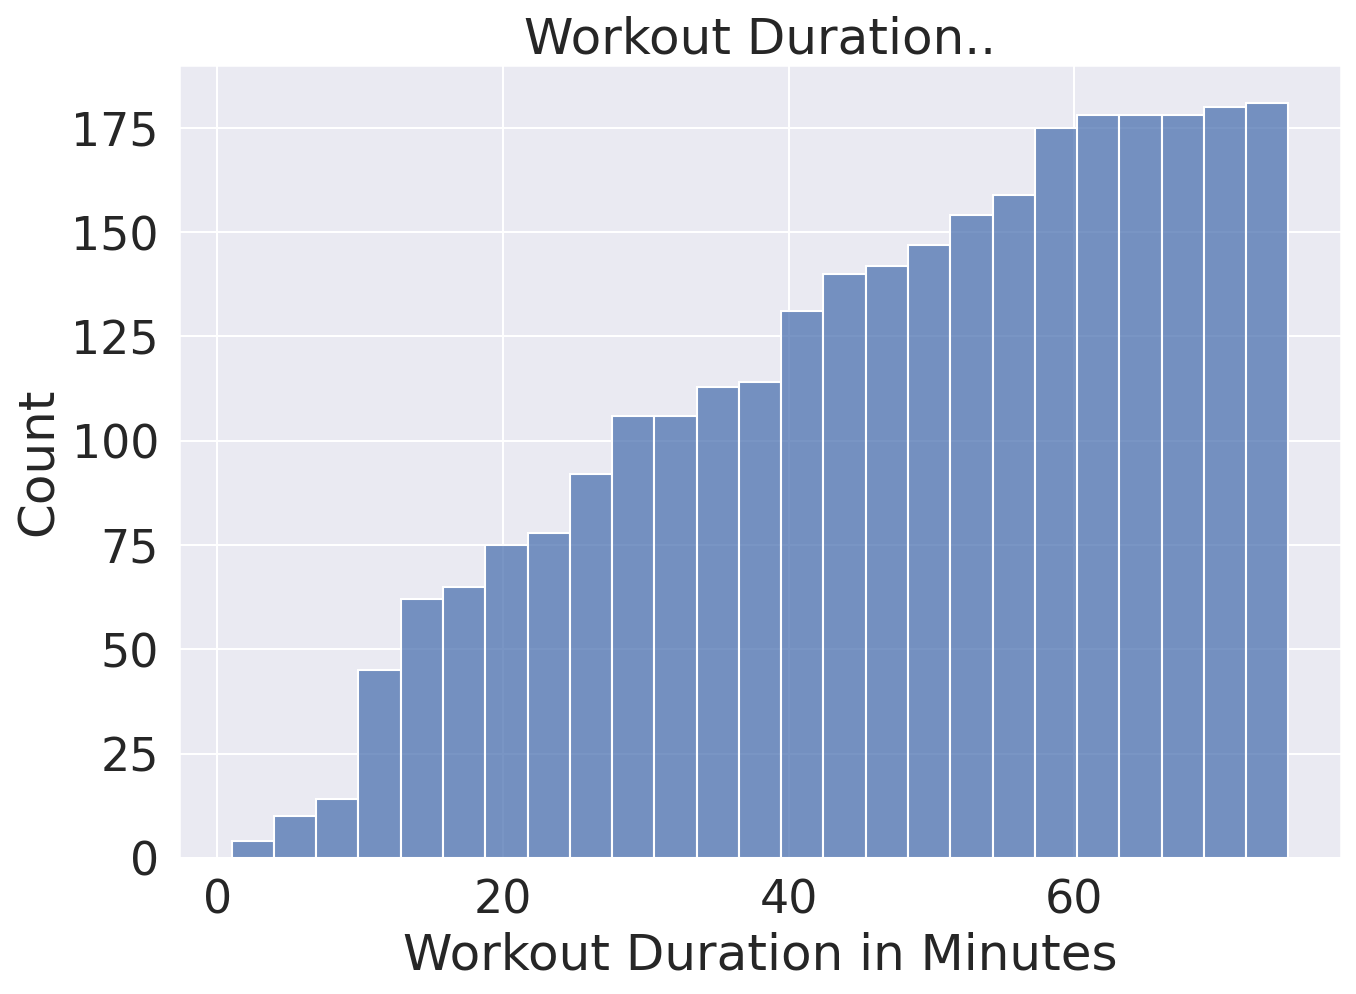

In [ ]:
fig, ax =  plt.subplots(1,1, figsize=(10,7), dpi=150)
sns.set_style("darkgrid")
sns.histplot(glog[glog.duration!=0].duration, bins = 25,ax=ax, palette ="magma", cumulative=True)
ax.set_title('Workout Duration..');
ax.set_xlabel("Workout Duration in Minutes")
ax.set_ylabel("Count")


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

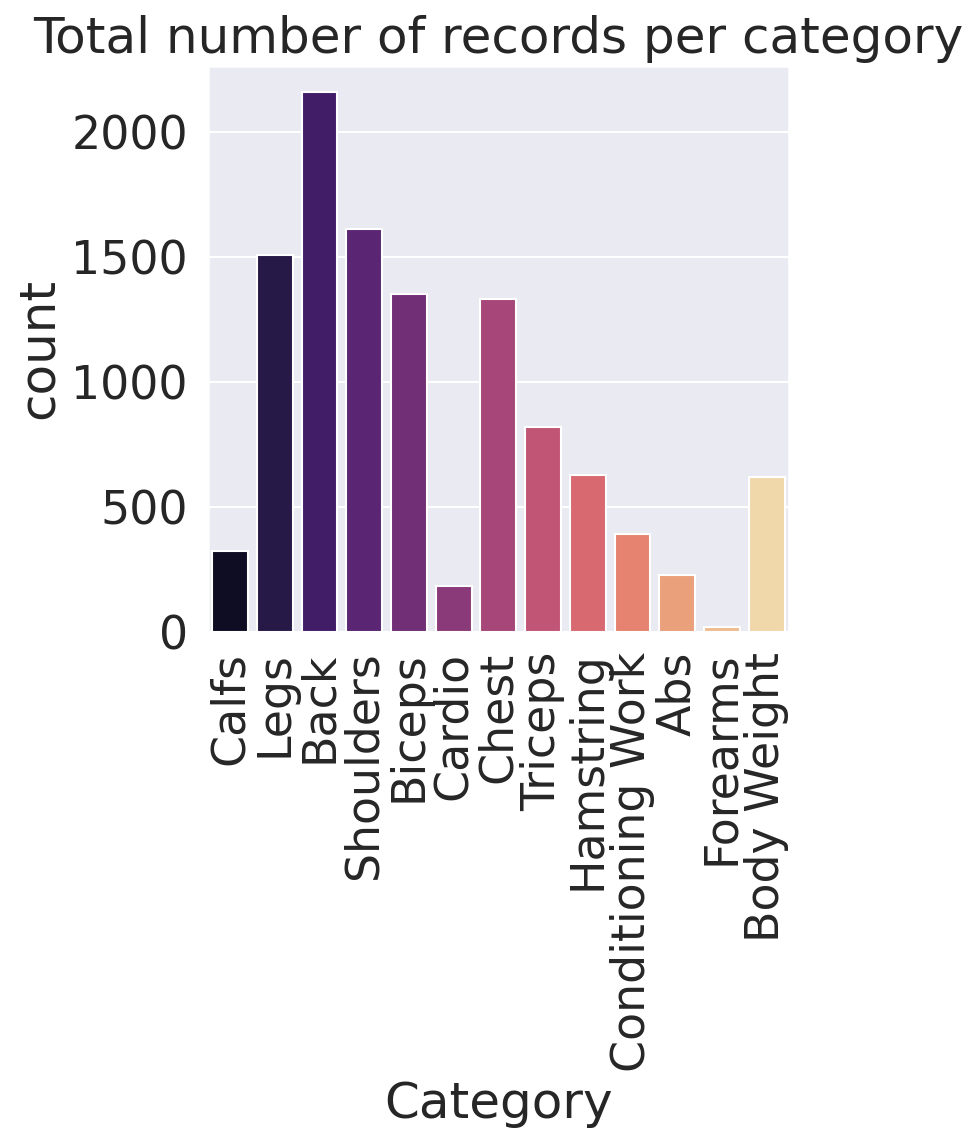

In [ ]:
fig, ax =  plt.subplots(1,1, figsize=(5,5), dpi=150)
sns.set_style("darkgrid")
sns.countplot(x="Category", data=glog.reset_index(),ax=ax, palette ="magma")
ax.set_title('Total number of records per category')
plt.xticks(rotation=90)

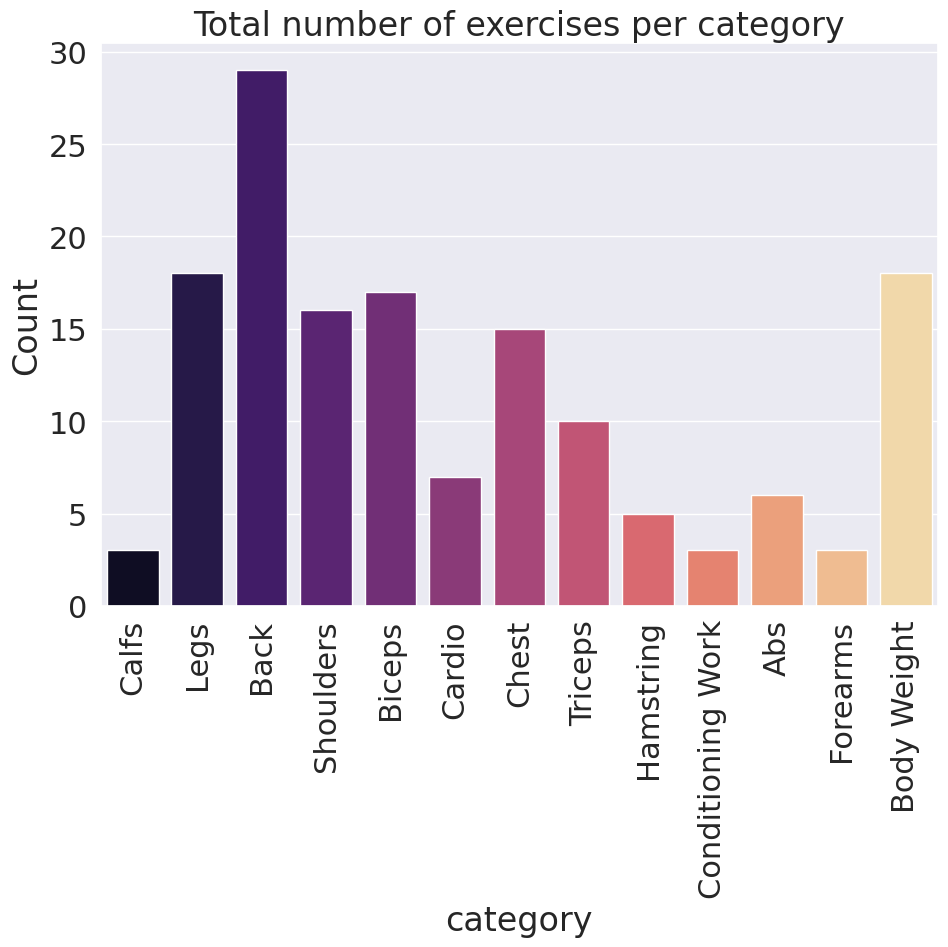

In [ ]:
fig, ax =  plt.subplots(1,1, figsize=(10,10), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)

sns.countplot(x="Category", data=glog[["Category", "Exercise"]].drop_duplicates(),ax=ax, palette ="magma")
ax.set_title('Total number of exercises per category');
ax.set_xlabel("category")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)
fig.tight_layout()

### Workout Volume and Reps Per Category


In [ ]:
by_date_cat_resampled_sum = glog.set_index("Date").groupby("Category").resample("W").sum()

In [ ]:
by_date_cat_resampled_sum.index.get_level_values(level=0).unique()

Index(['Abs', 'Back', 'Biceps', 'Body Weight', 'Calfs', 'Cardio', 'Chest',
       'Conditioning Work', 'Forearms', 'Hamstring', 'Legs', 'Shoulders',
       'Triceps'],
      dtype='object', name='Category')

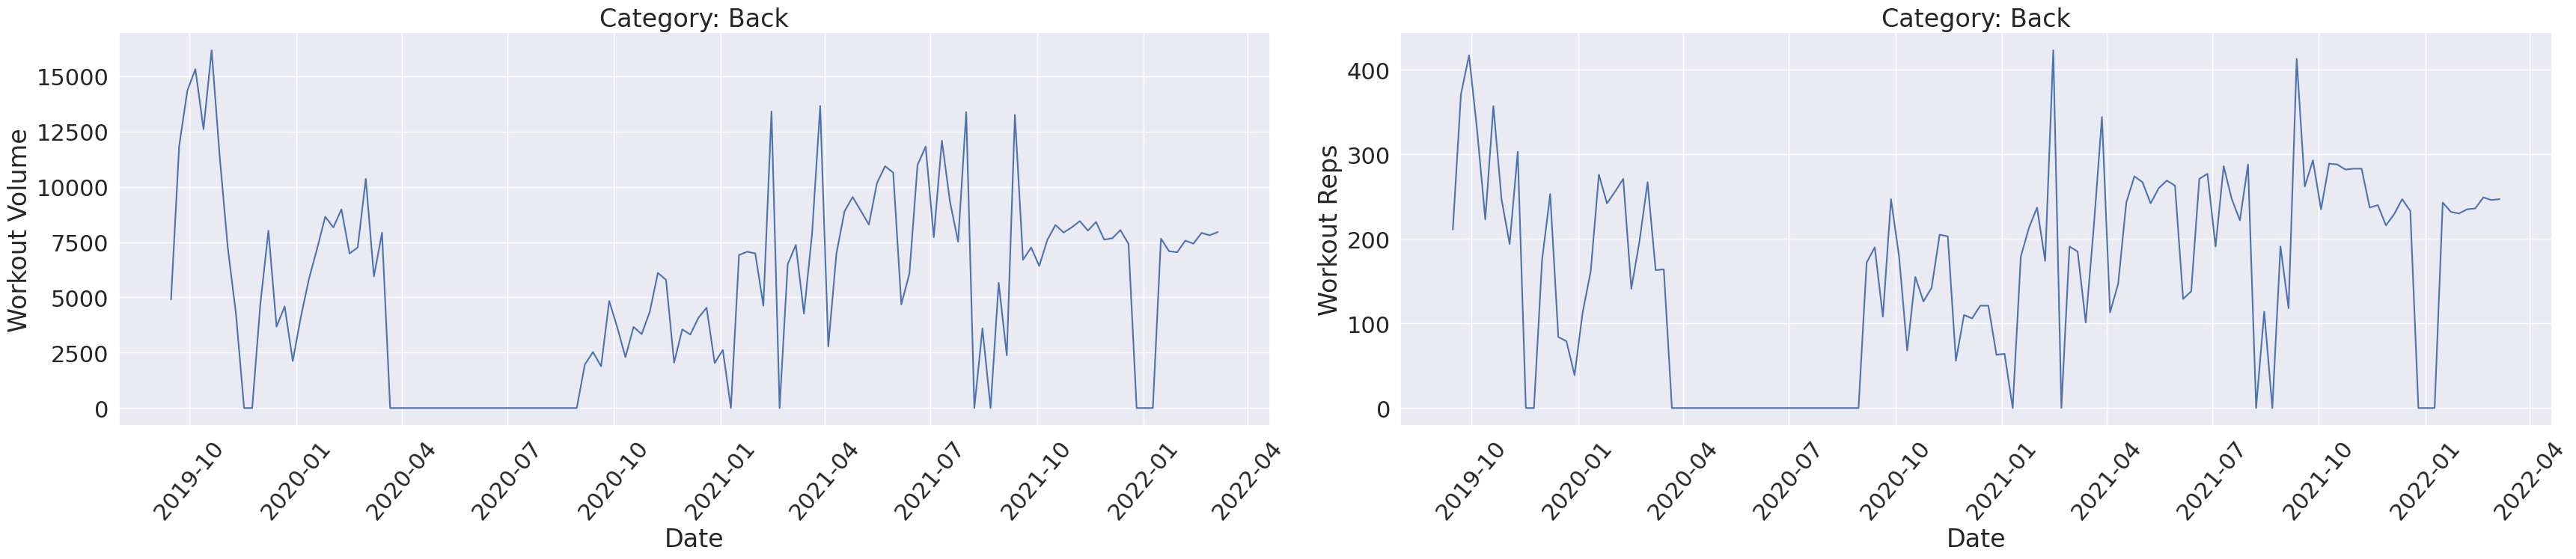

In [ ]:
# Back
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Back"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Back');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Back');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()


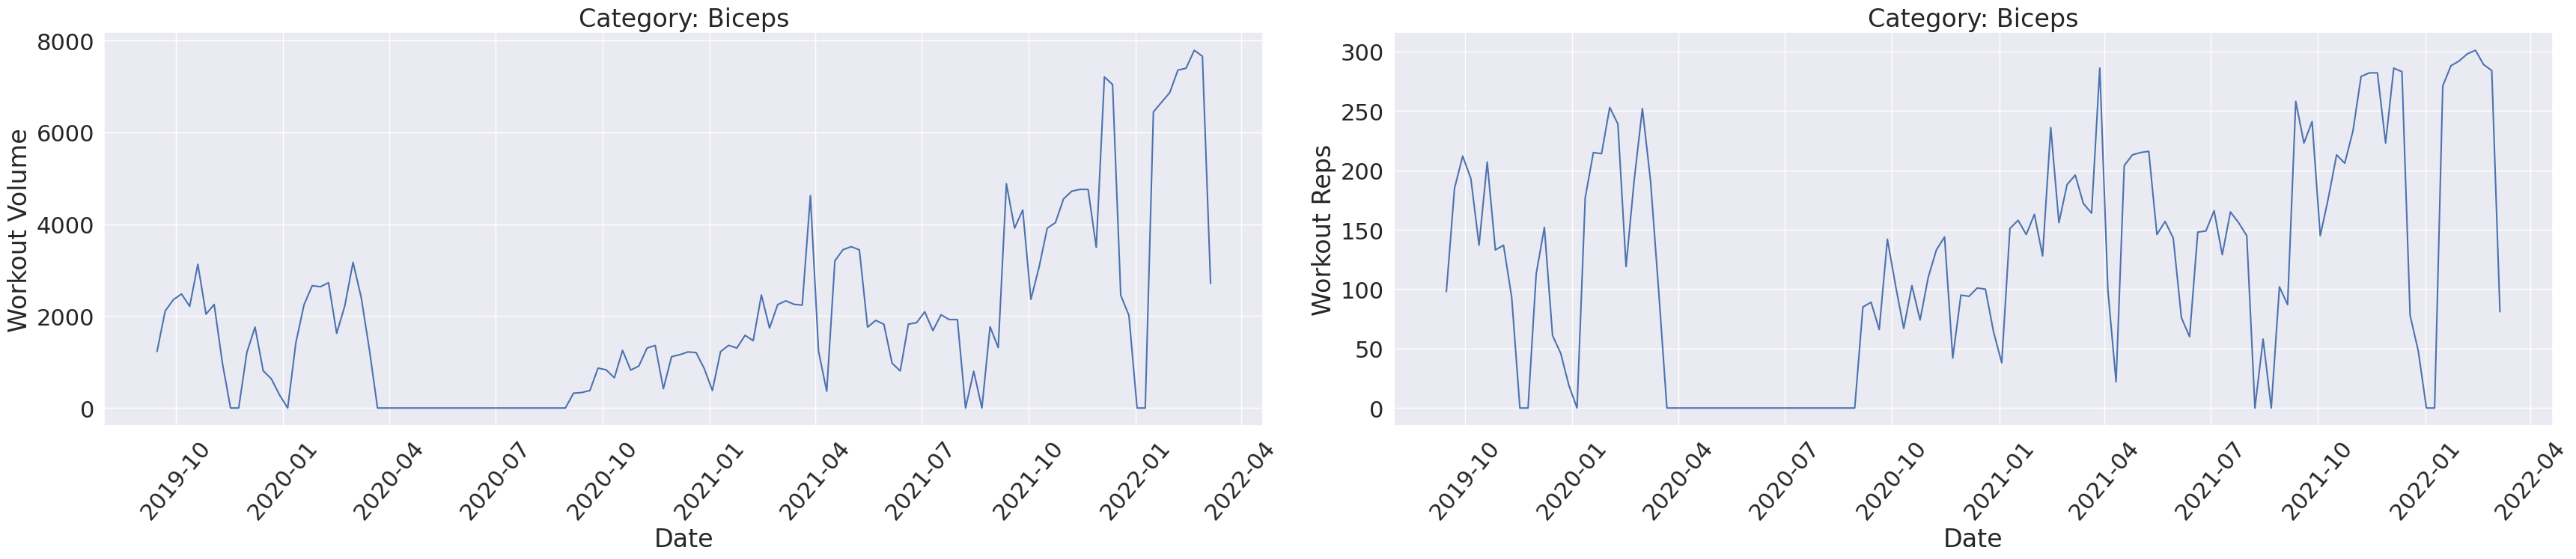

In [ ]:
# Biceps
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Biceps"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Biceps');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Biceps');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

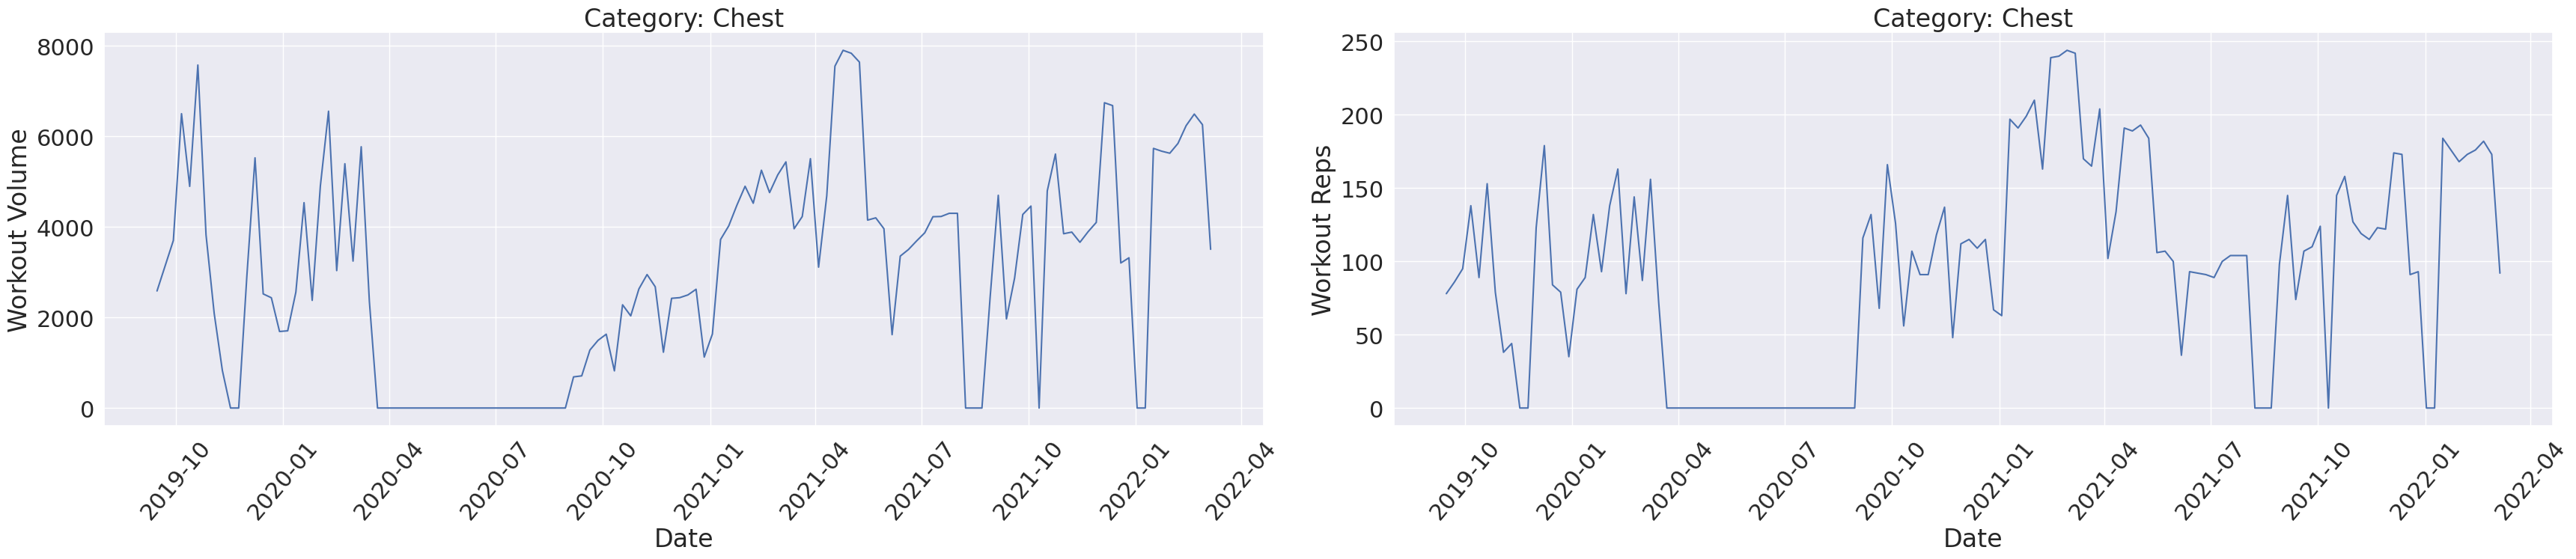

In [ ]:
# Chest
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Chest"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Chest');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Chest');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

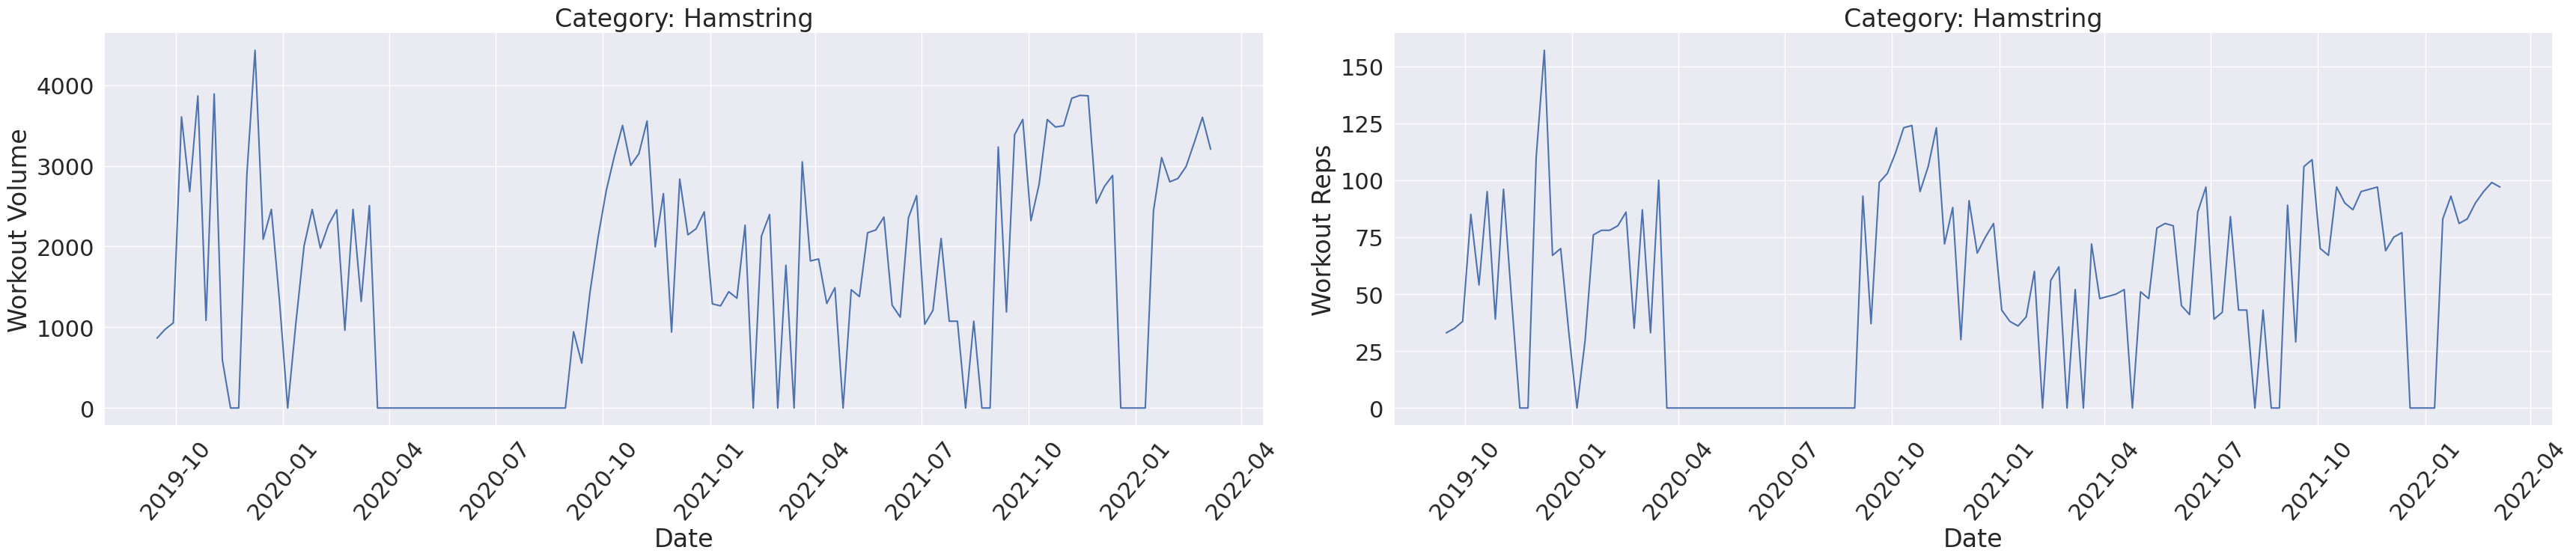

In [ ]:
# Hamstring
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Hamstring"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Hamstring');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Hamstring');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

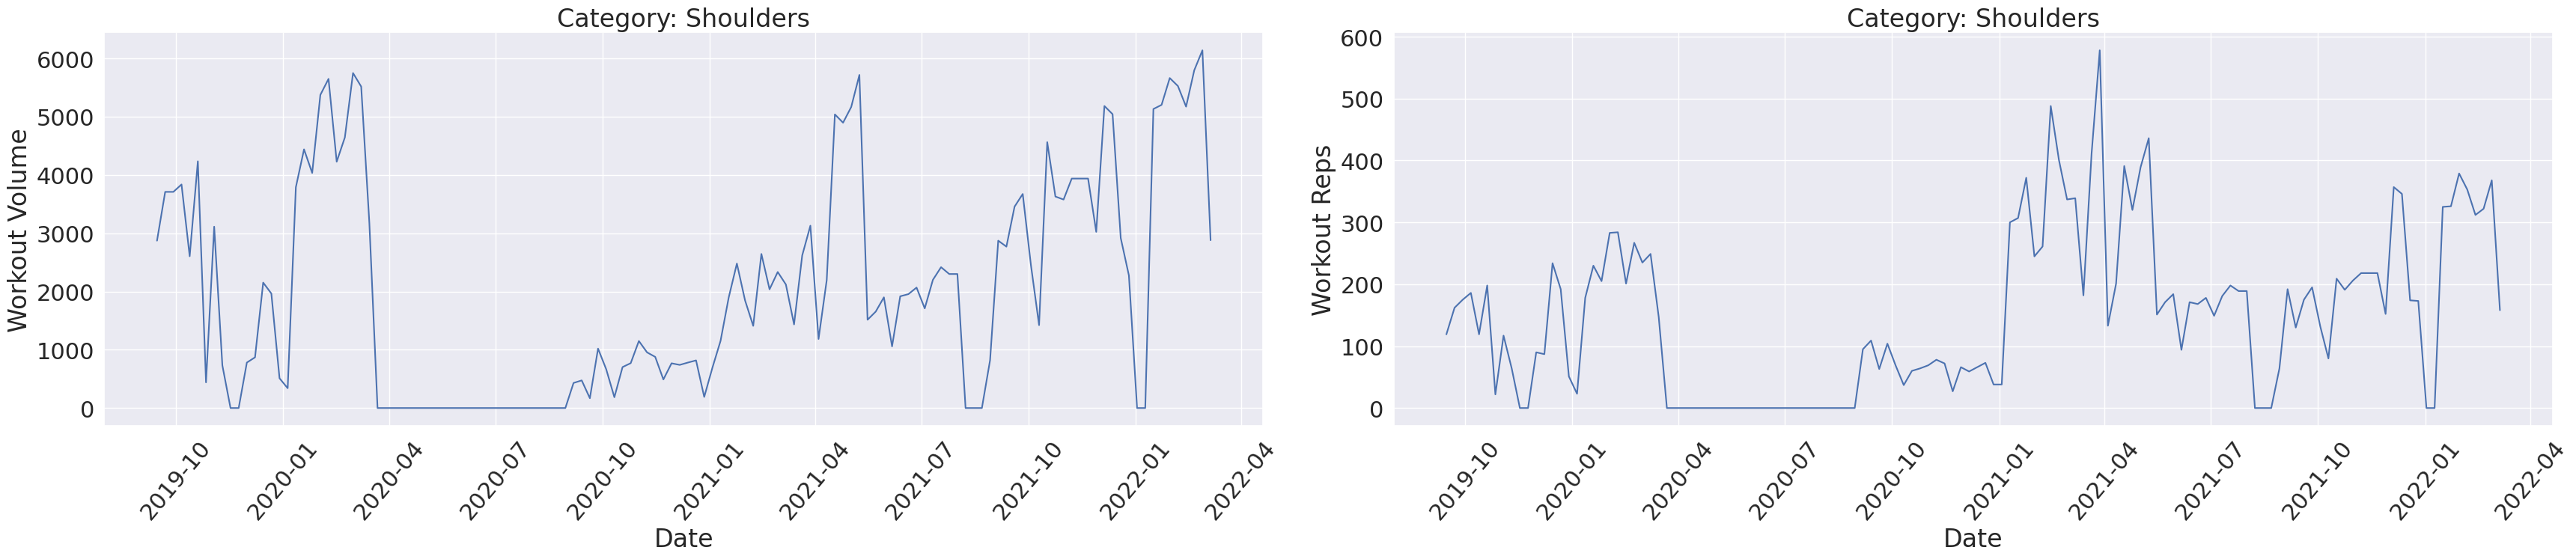

In [ ]:
# Shoulders
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Shoulders"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Shoulders');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Shoulders');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

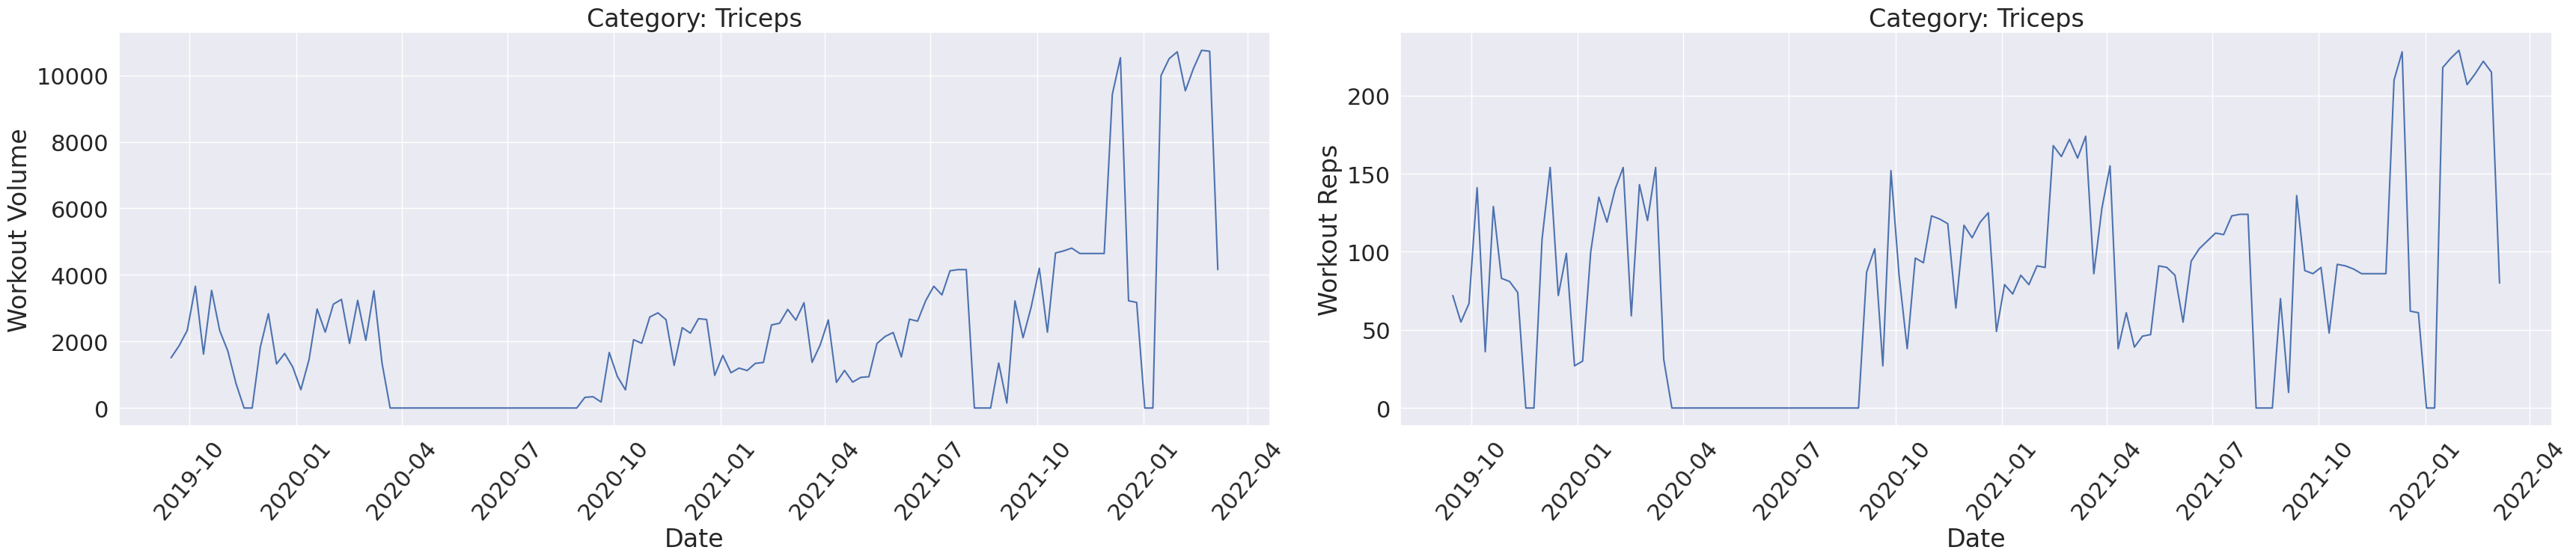

In [ ]:
# Triceps
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Triceps"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Triceps');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Triceps');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

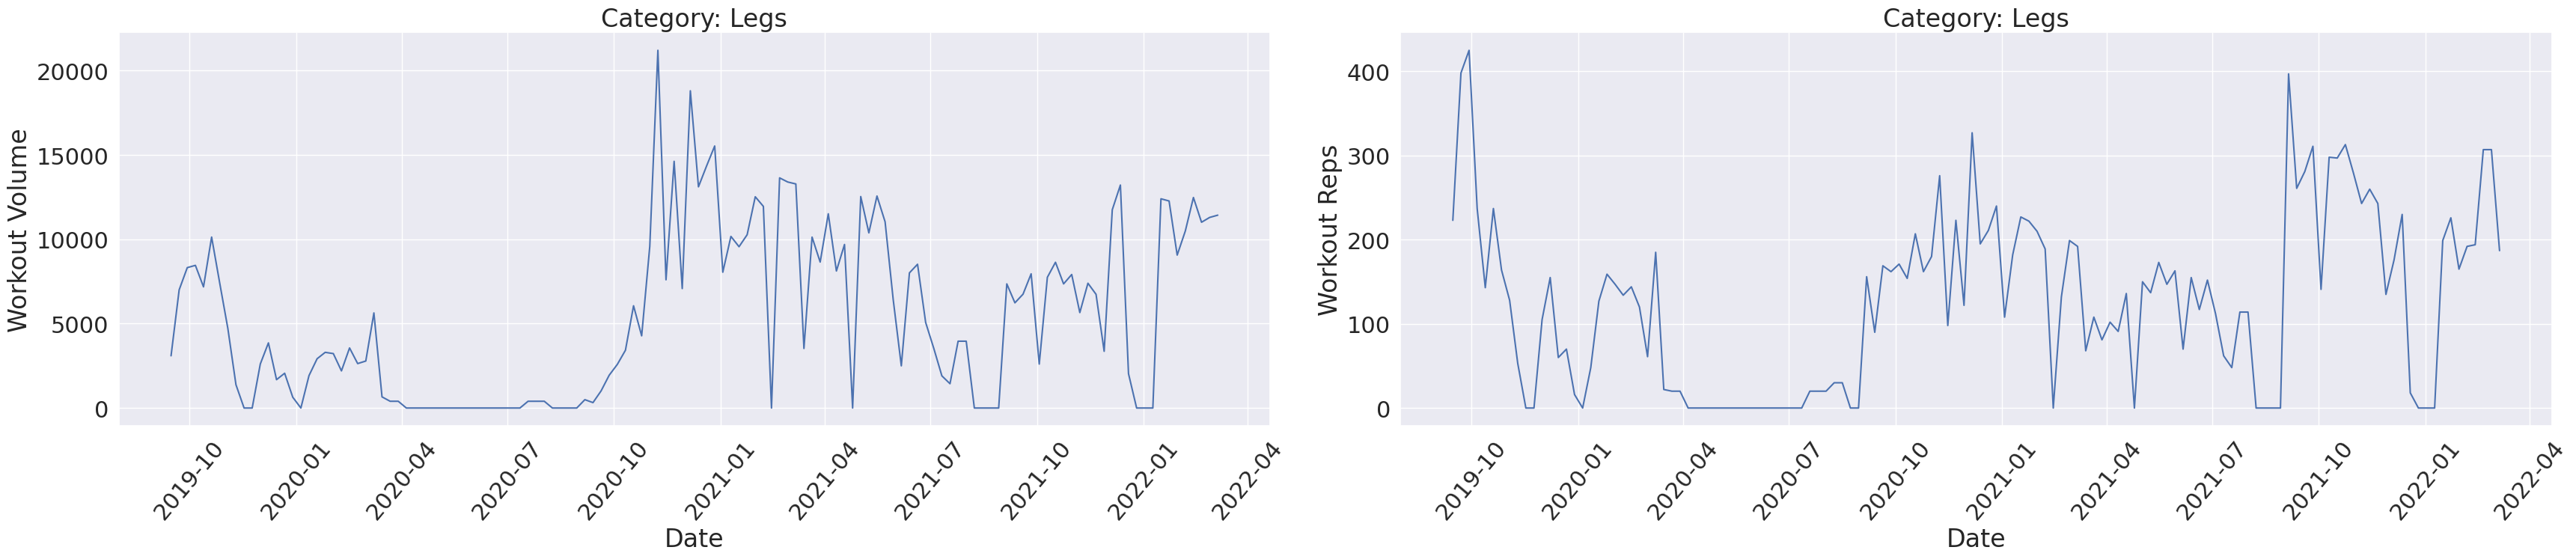

In [ ]:
# Legs
fig, ax =  plt.subplots(1,2, figsize=(35,8), dpi=100)
# sns.set_style("darkgrid")
sns.set(font_scale=2)
df = by_date_cat_resampled_sum.loc["Legs"]

sns.lineplot(df.index, df.Volume, ax=ax[0], palette ="jet",  markers=True, dashes=True)
ax[0].set_title('Category: Legs');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)


sns.lineplot(df.index, df.Reps, ax=ax[1], palette ="magma",  markers=True, dashes=True)
ax[1].set_title('Category: Legs');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Reps")
ax[1].tick_params(axis="x", rotation=50)
fig.tight_layout()

### Trend Analaysis

In [ ]:
by_date_cat_resampled_sum.index.get_level_values(0).unique()

Index(['Abs', 'Back', 'Biceps', 'Body Weight', 'Calfs', 'Cardio', 'Chest',
       'Conditioning Work', 'Forearms', 'Hamstring', 'Legs', 'Shoulders',
       'Triceps'],
      dtype='object', name='Category')

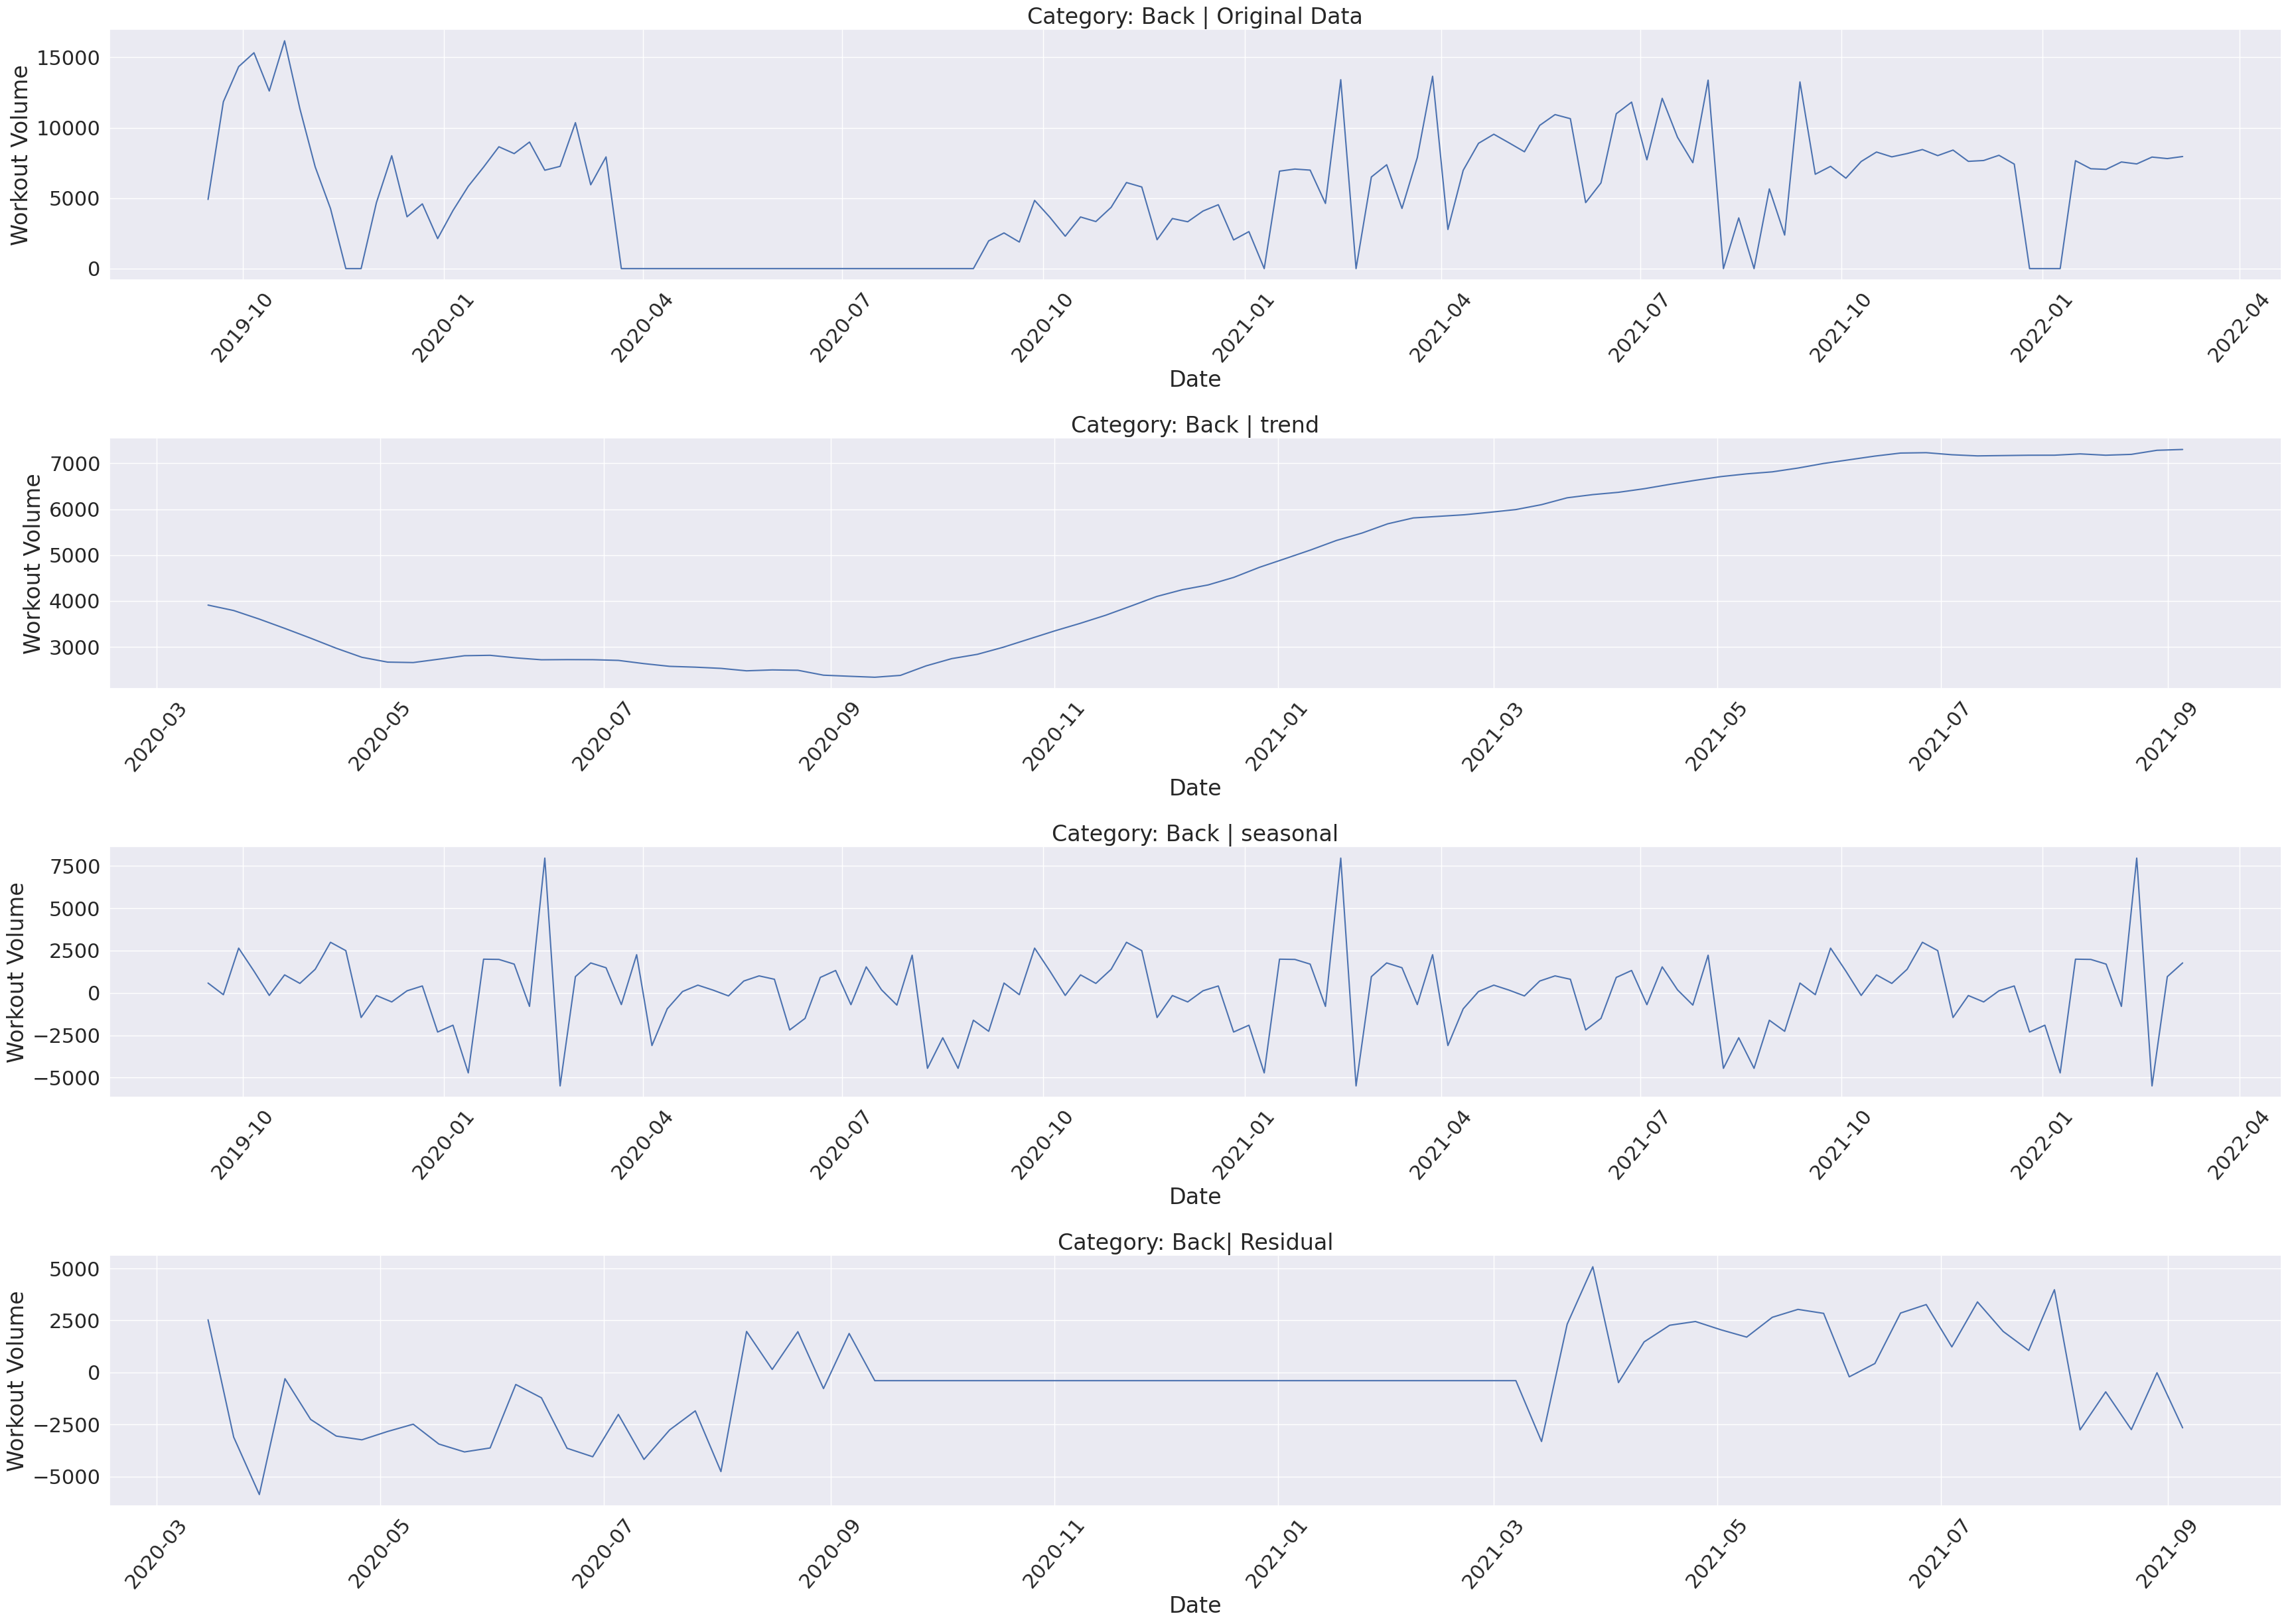

In [ ]:
# Back
df = by_date_cat_resampled_sum.loc["Back"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Back | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Back | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Back | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Back| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

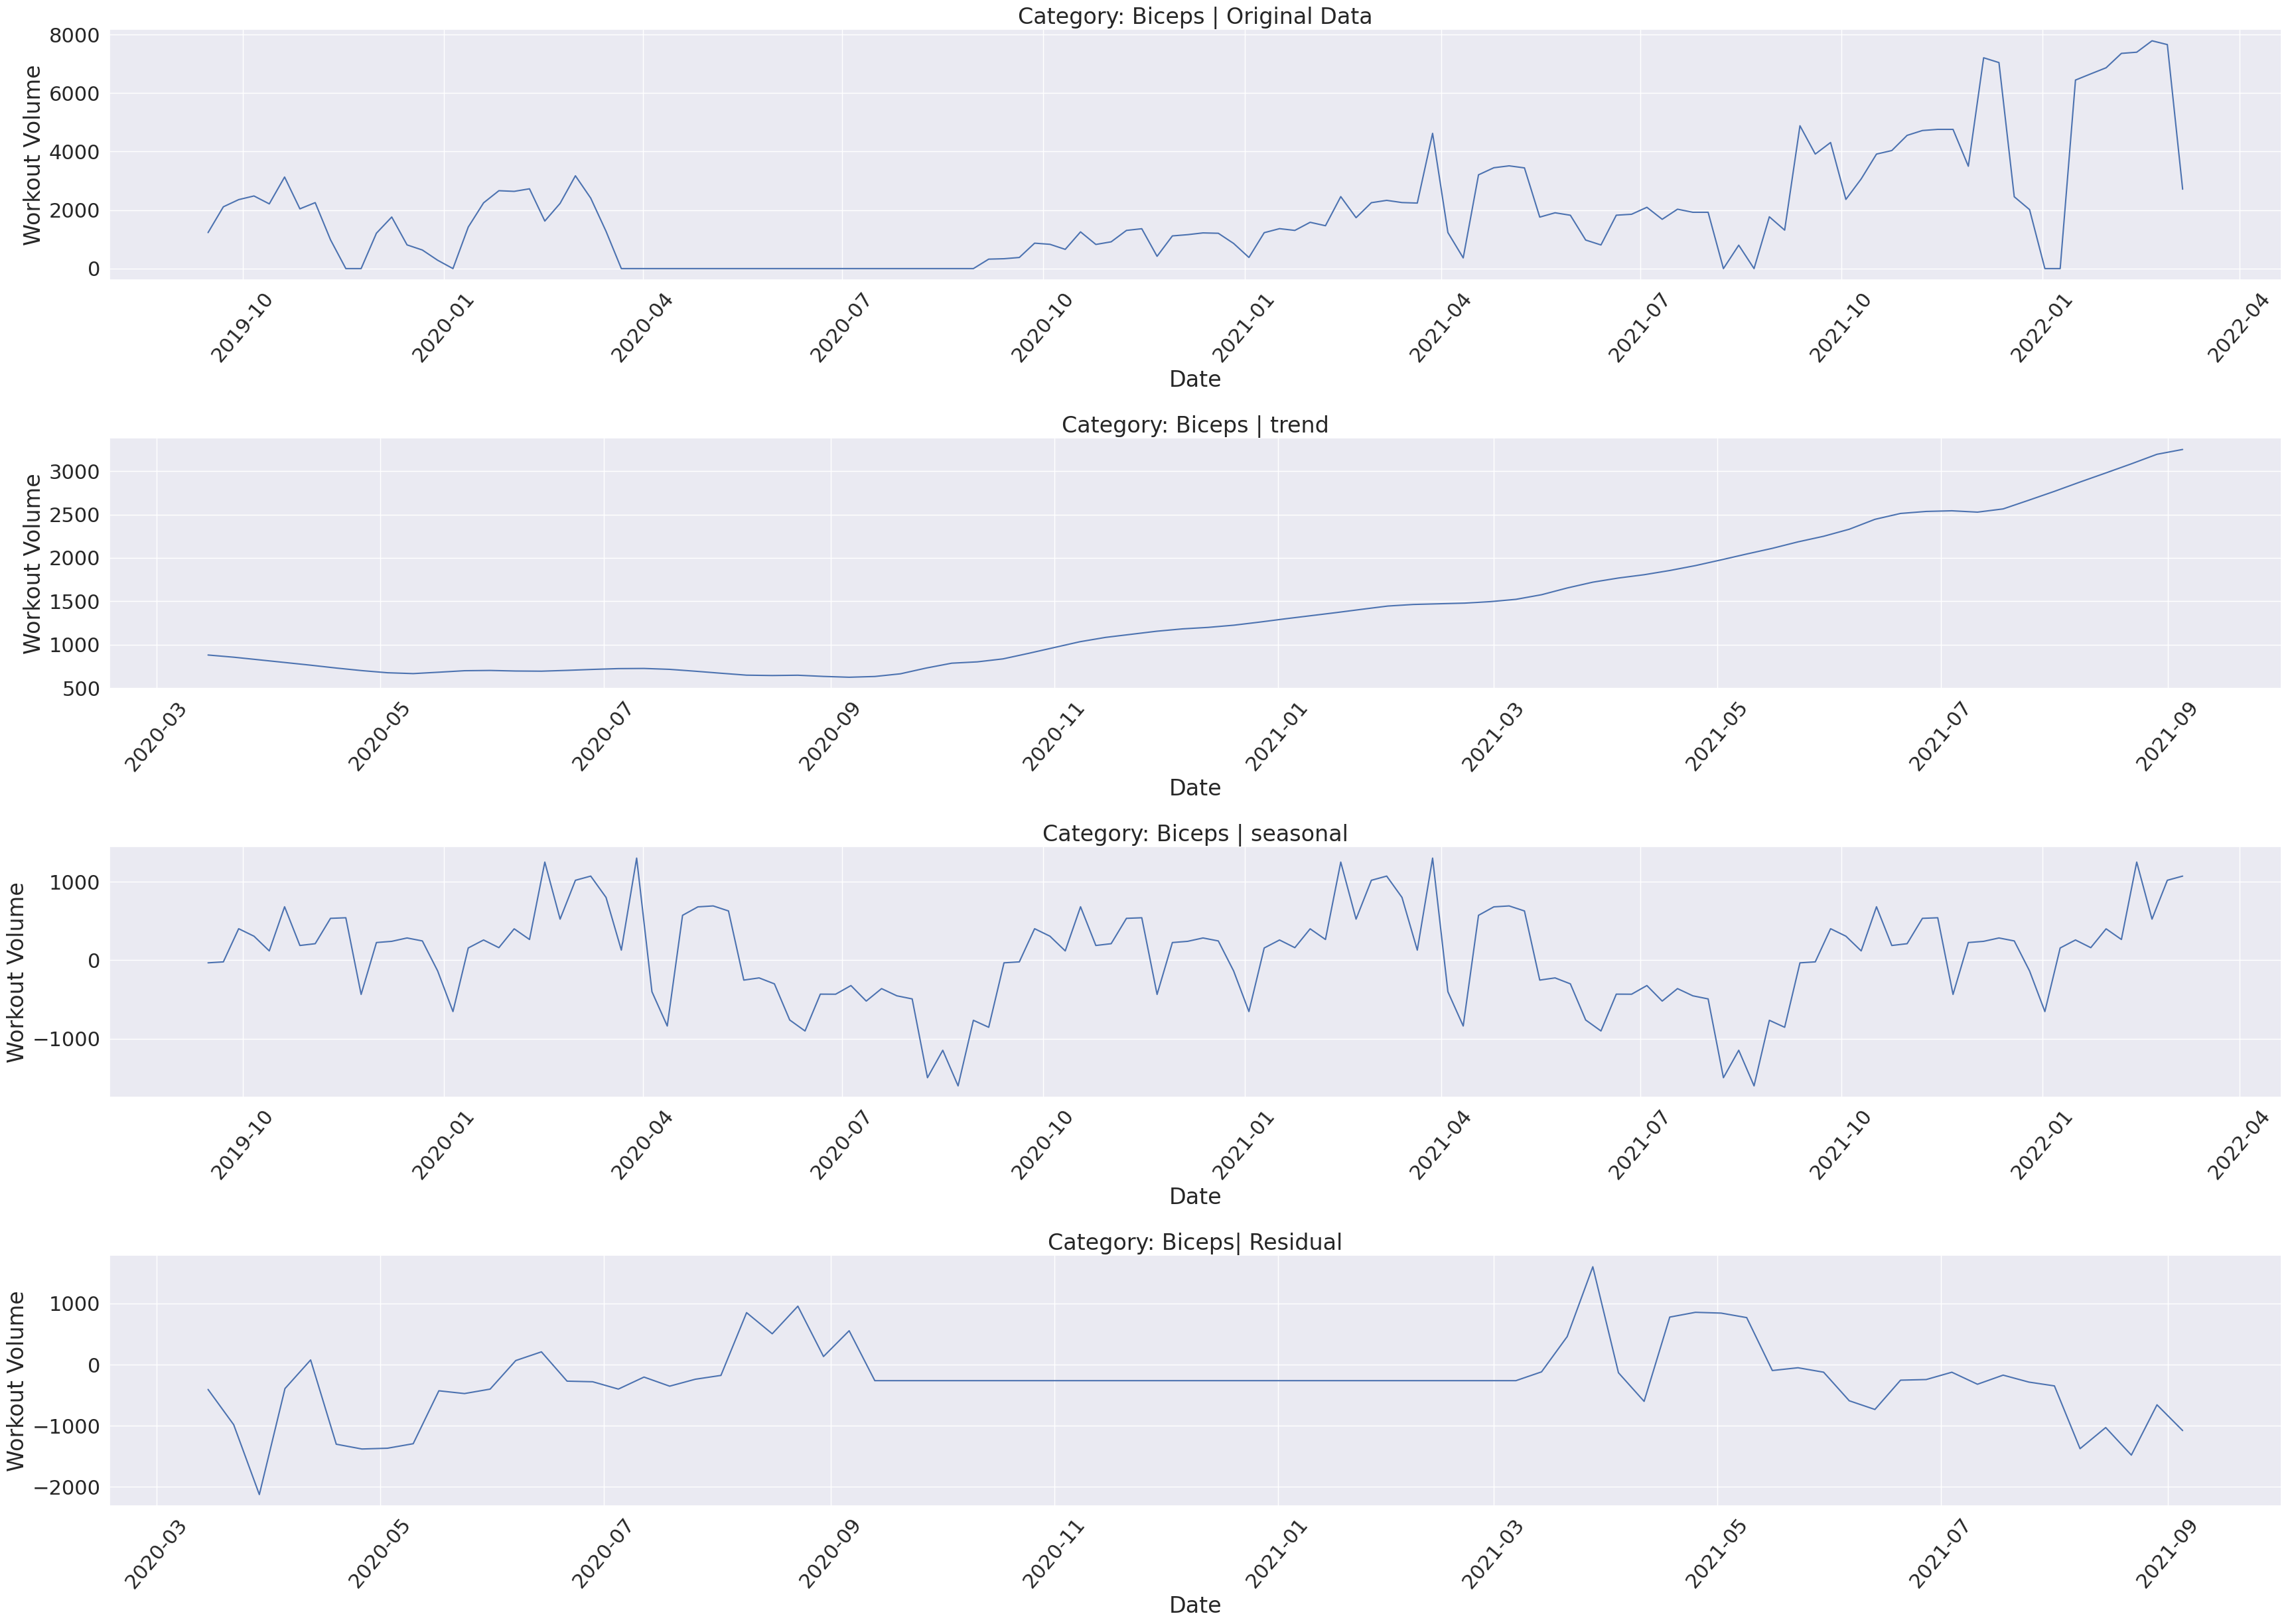

In [ ]:
# Biceps
df = by_date_cat_resampled_sum.loc["Biceps"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Biceps | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Biceps | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Biceps | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Biceps| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

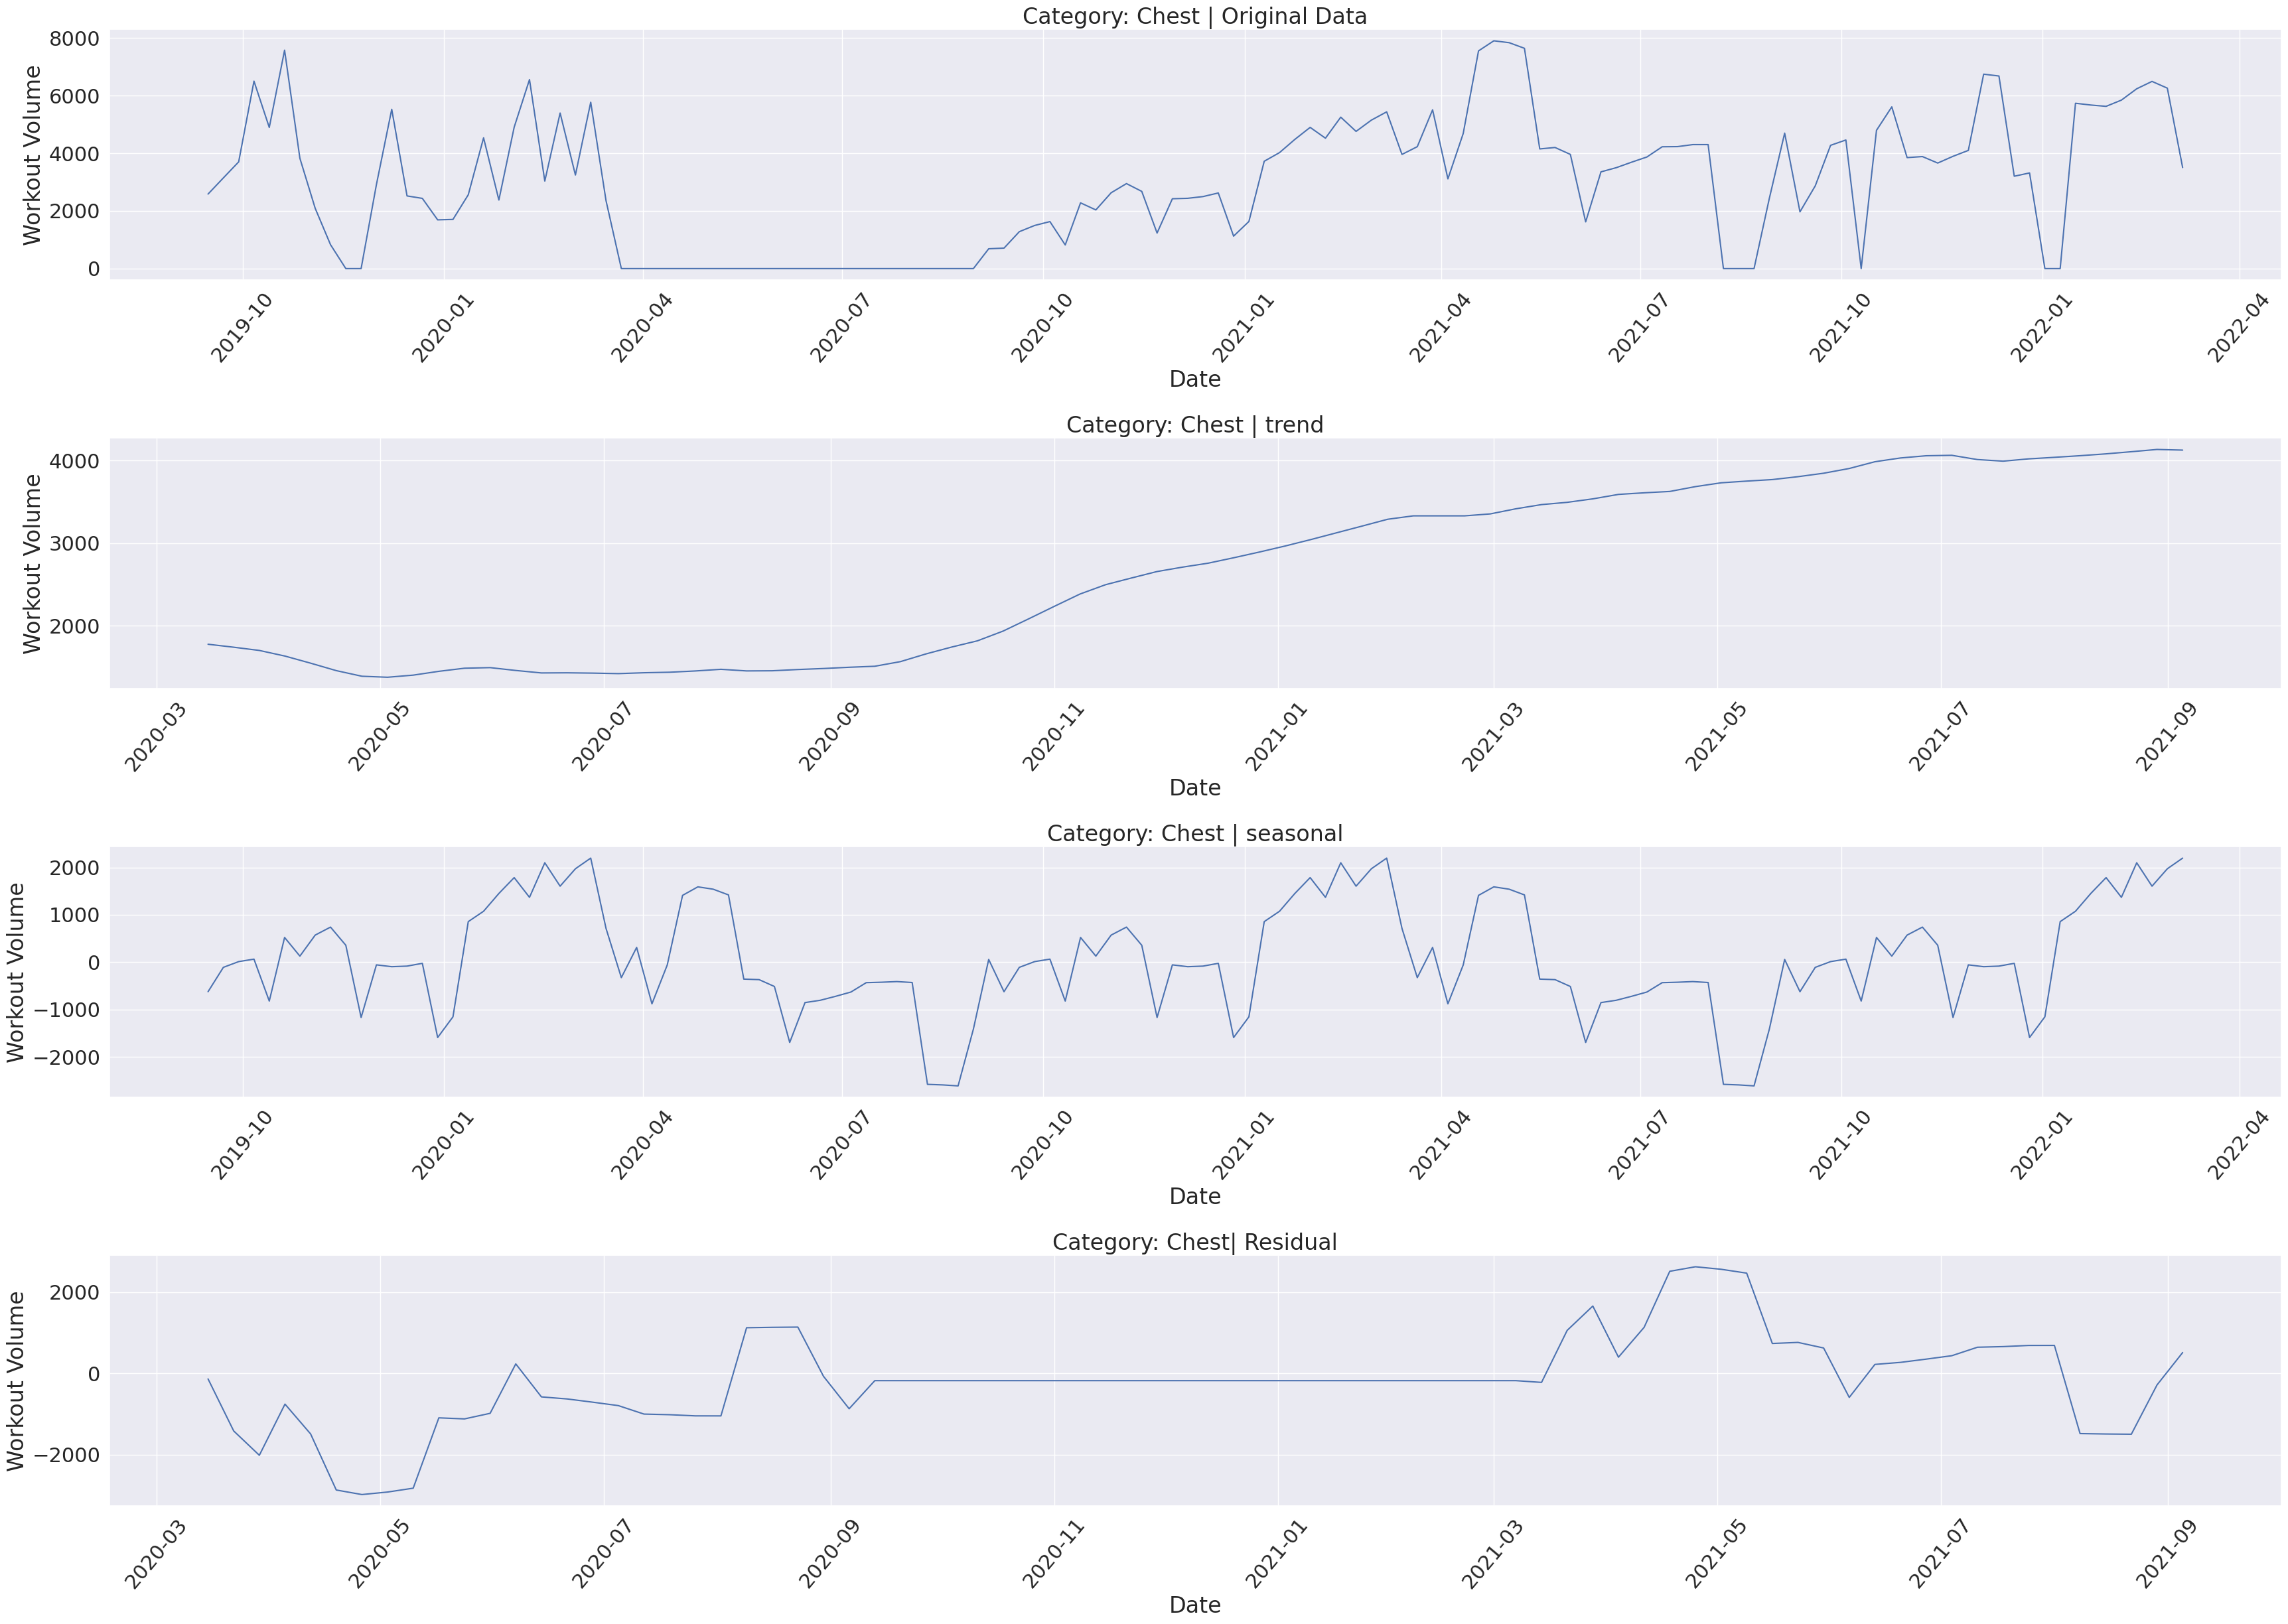

In [ ]:
# Chest
df = by_date_cat_resampled_sum.loc["Chest"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Chest | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Chest | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Chest | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Chest| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

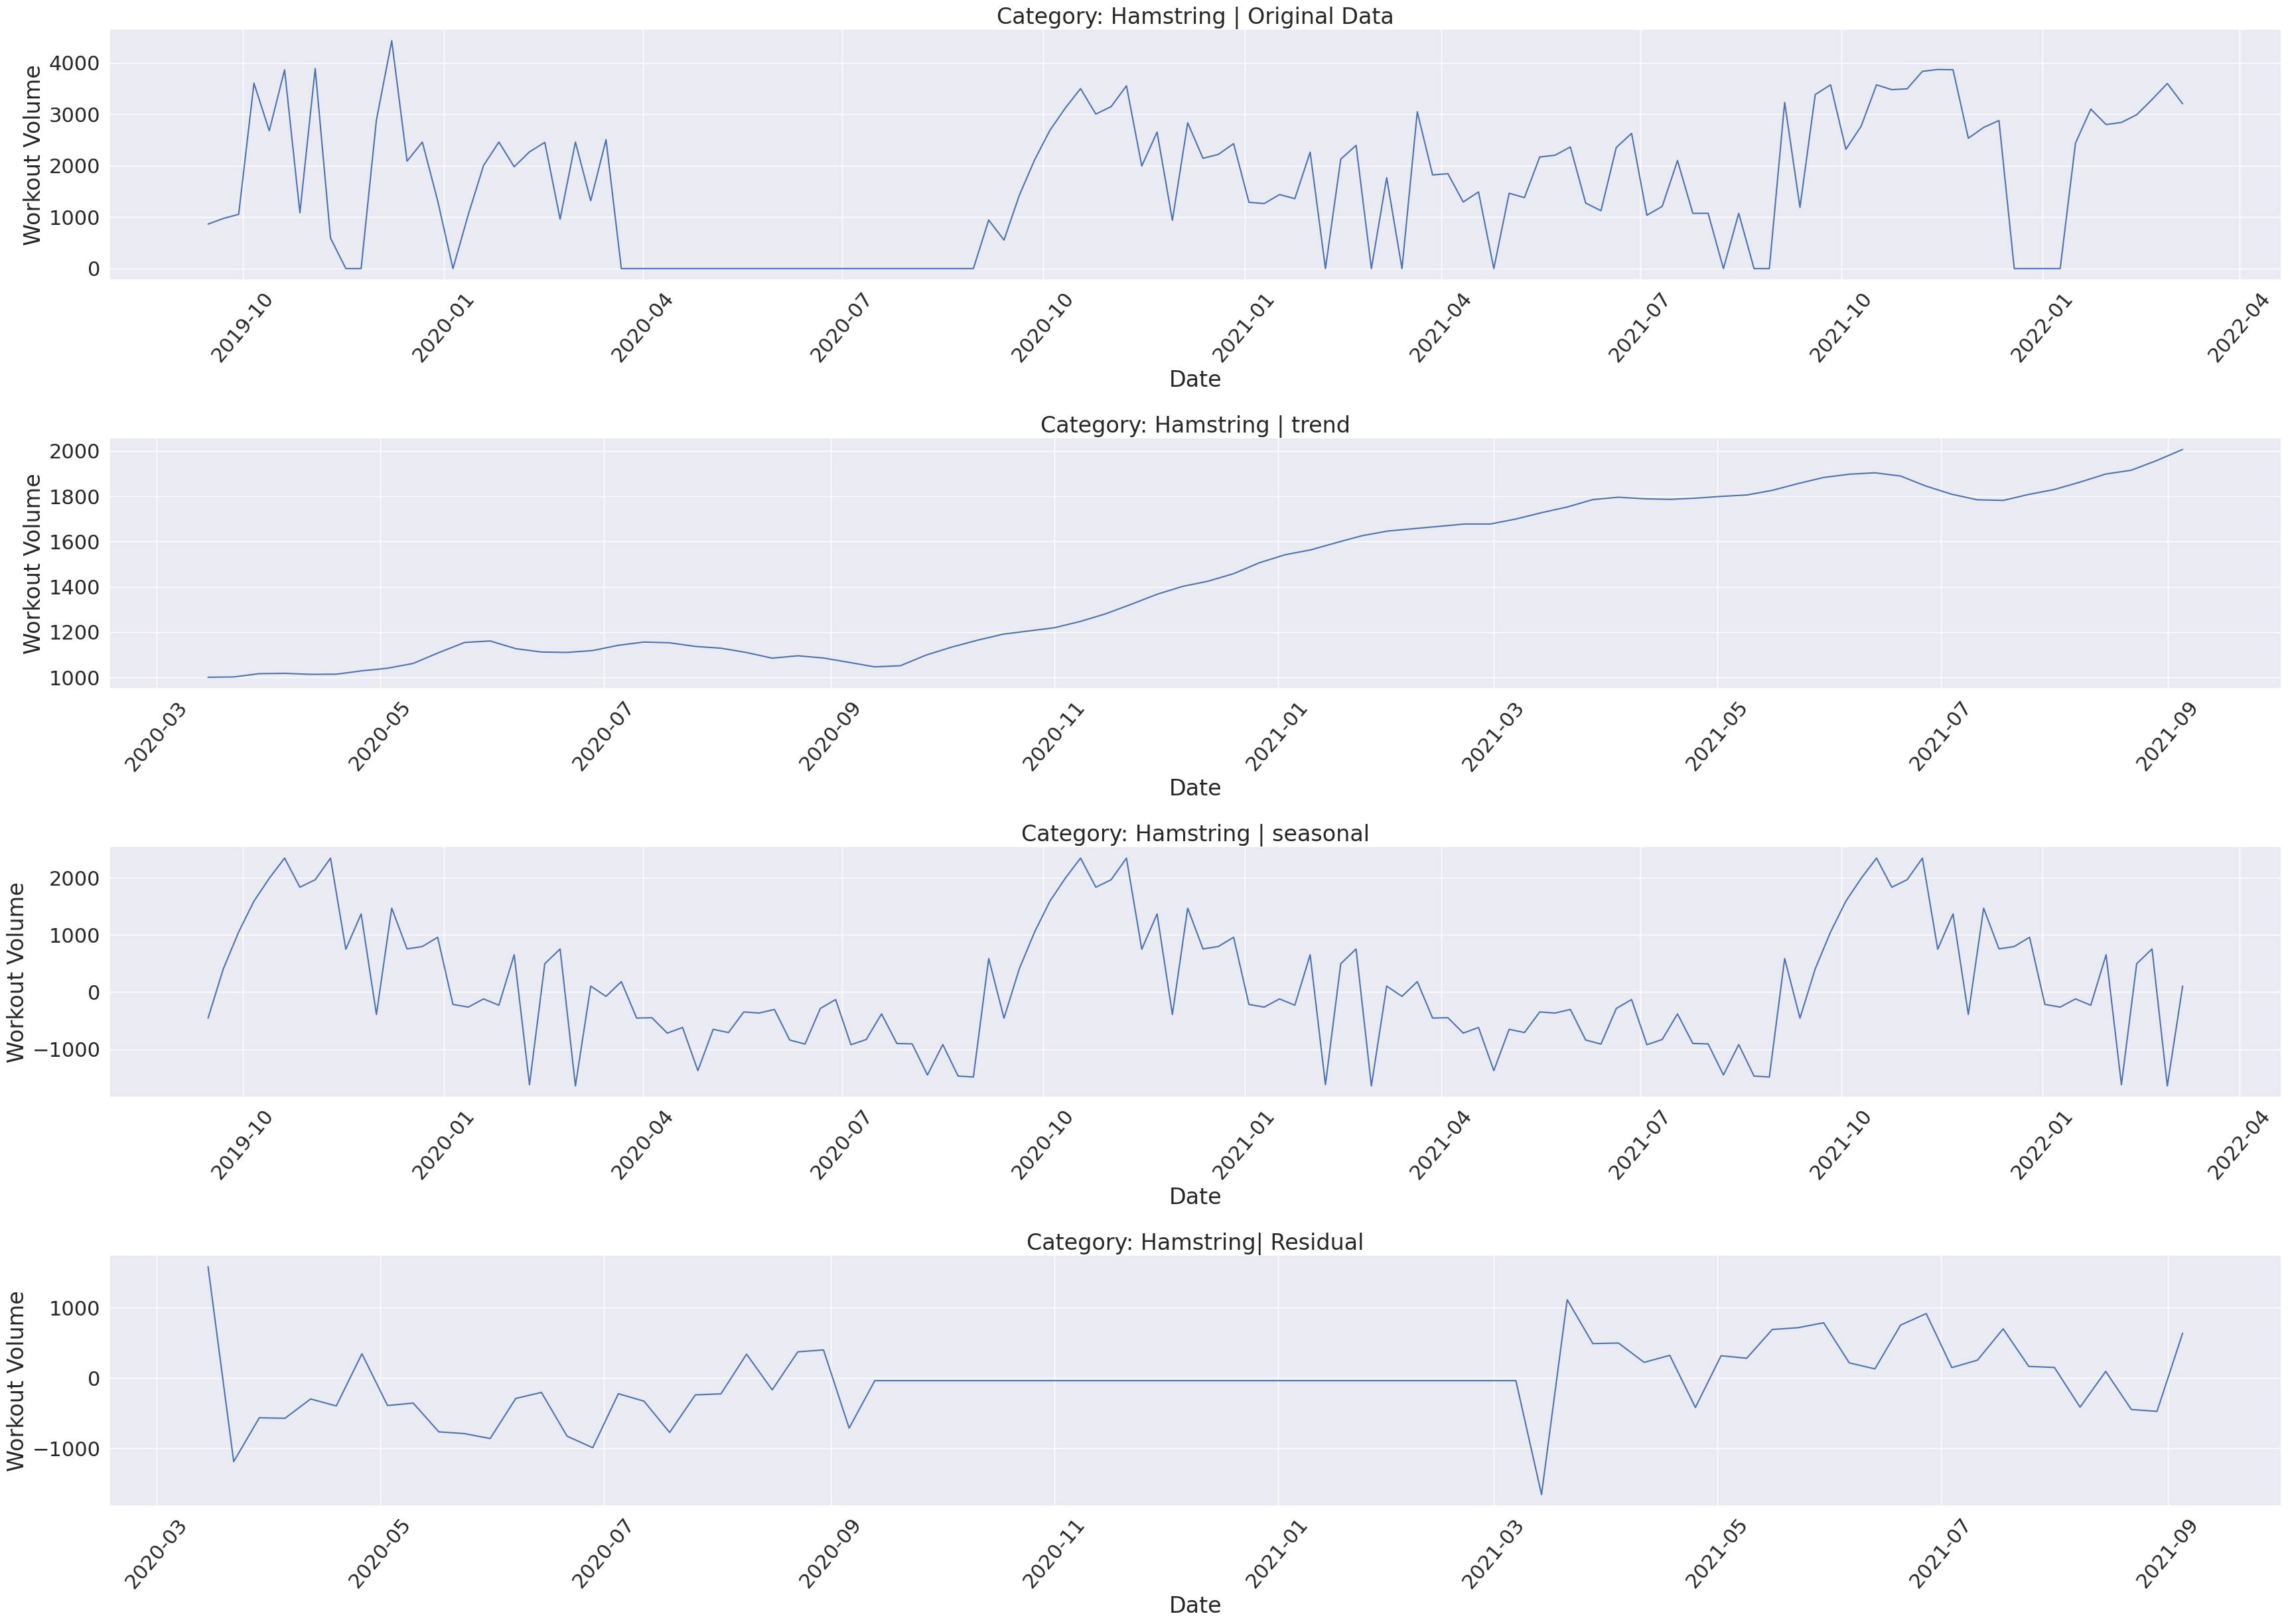

In [ ]:
# Hamstring
df = by_date_cat_resampled_sum.loc["Hamstring"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Hamstring | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Hamstring | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Hamstring | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Hamstring| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

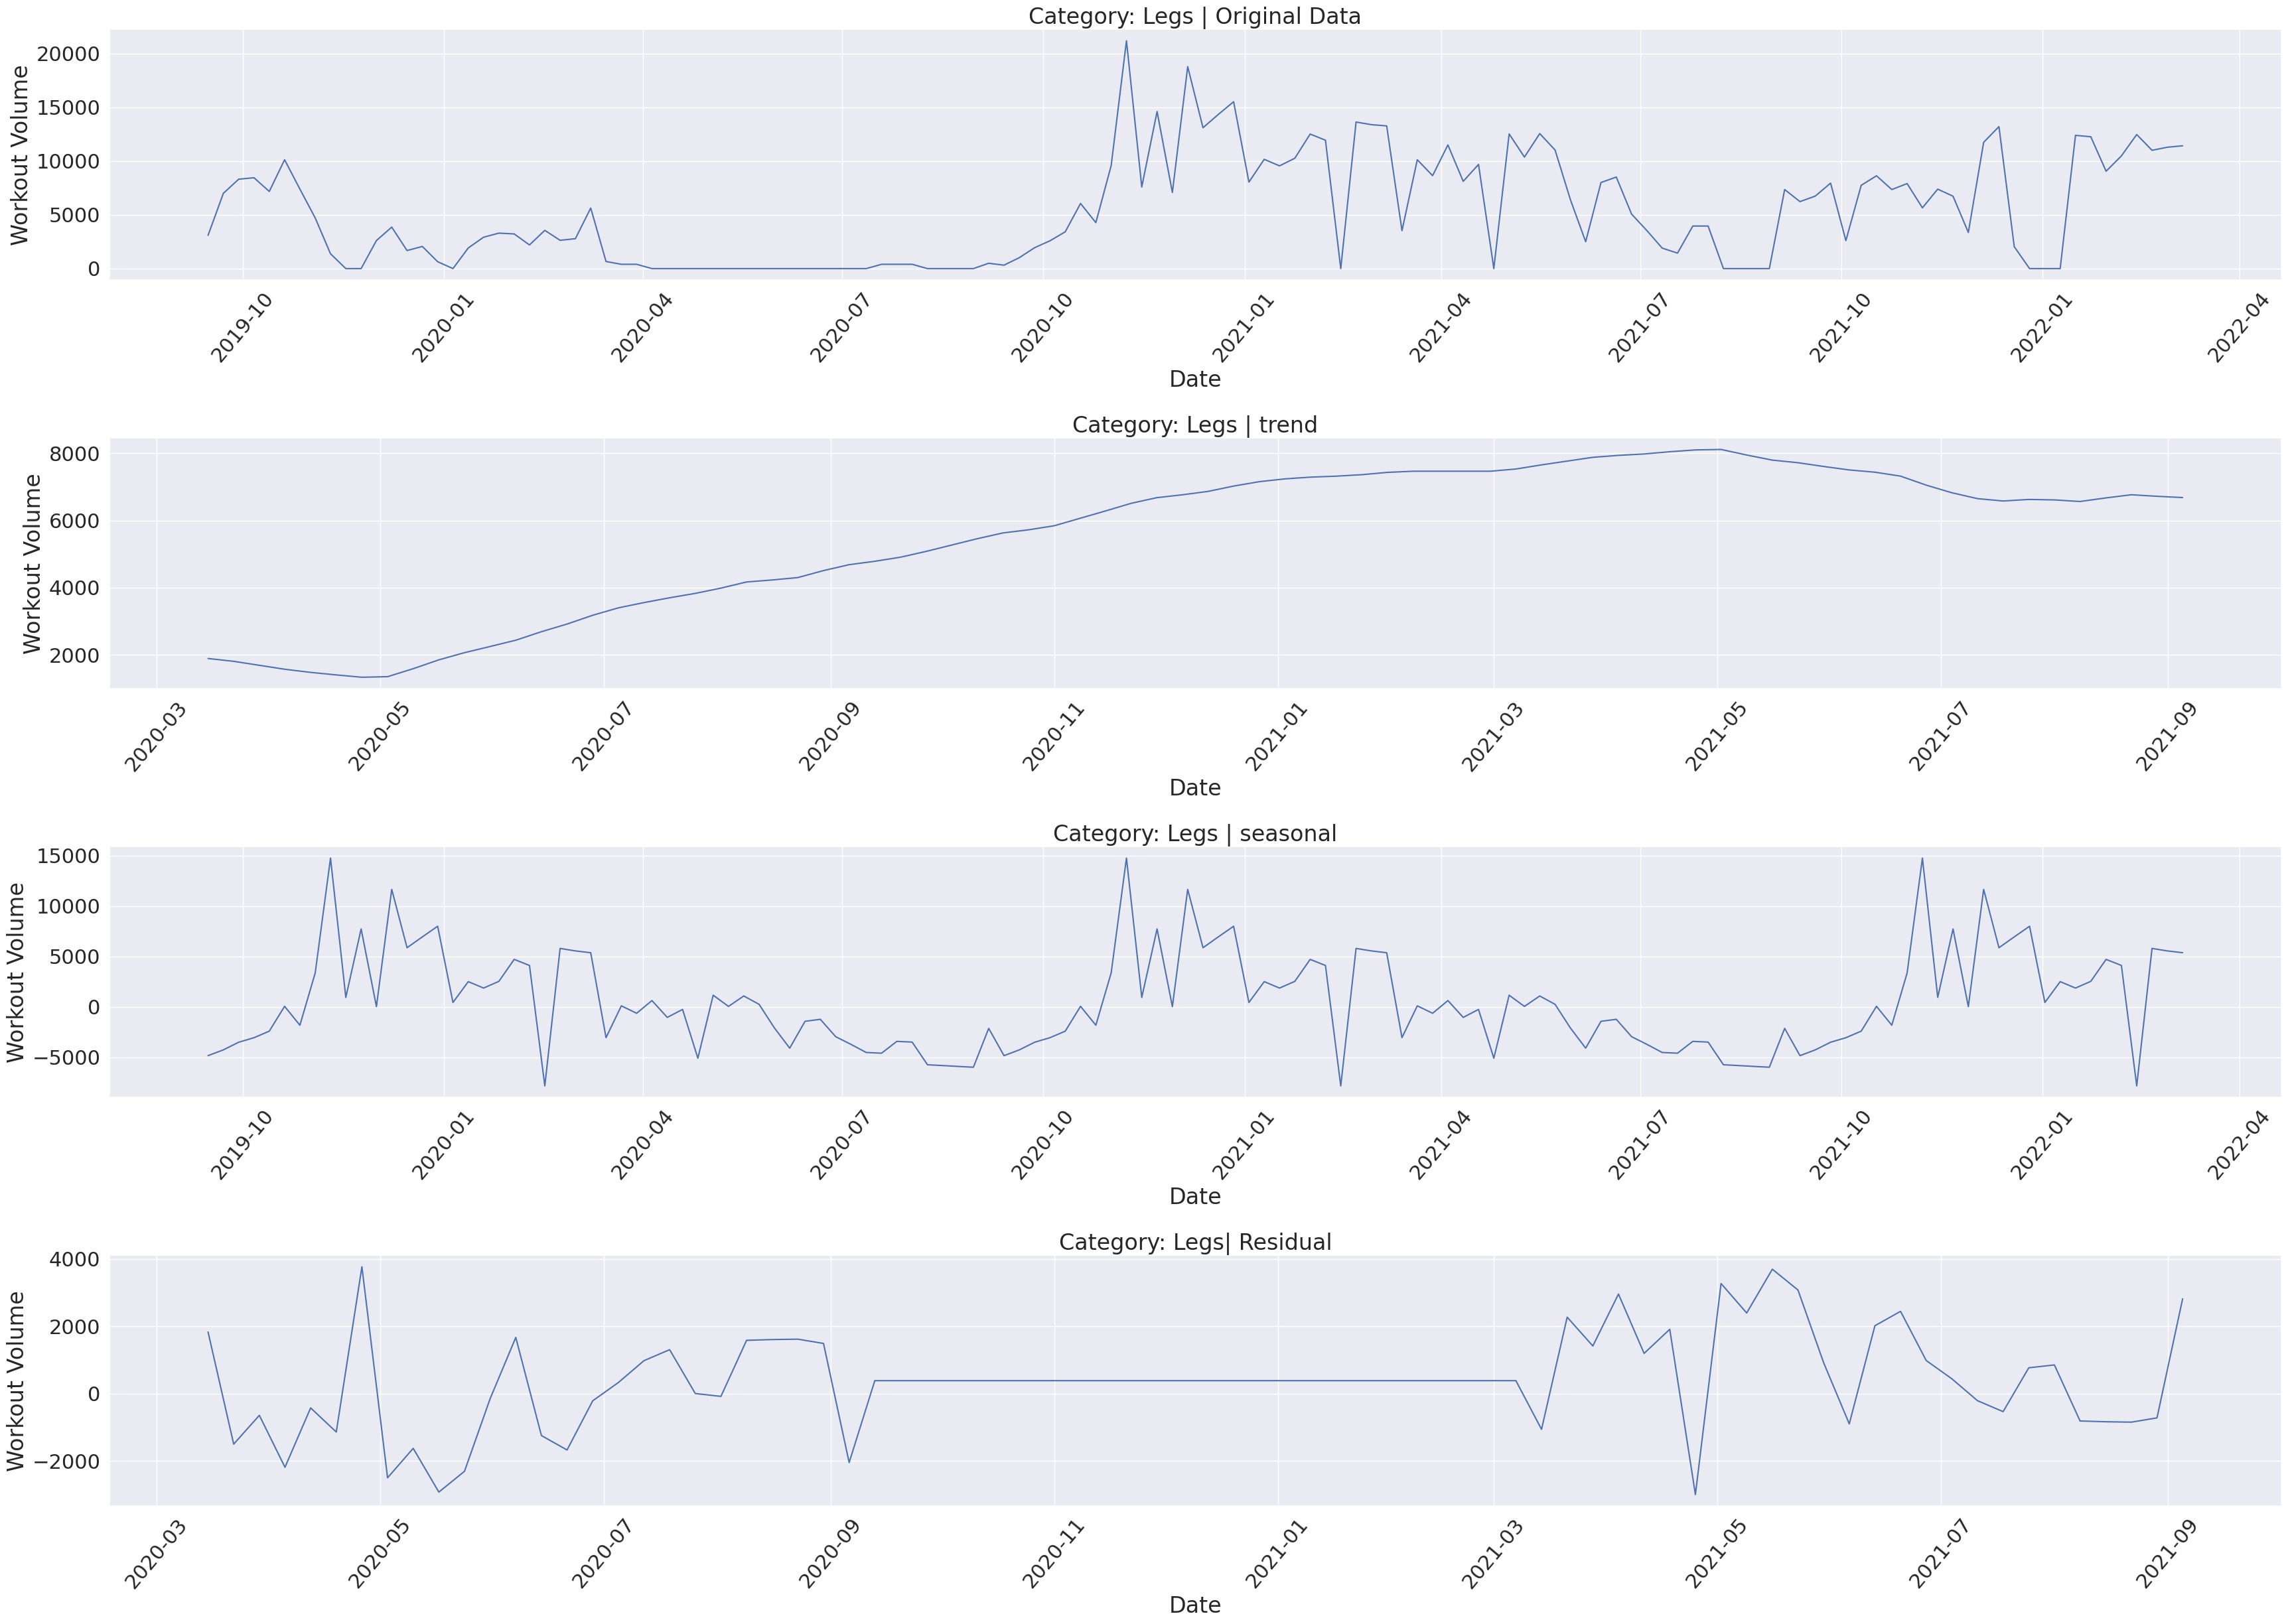

In [ ]:
# Legs
df = by_date_cat_resampled_sum.loc["Legs"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Legs | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Legs | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Legs | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Legs| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

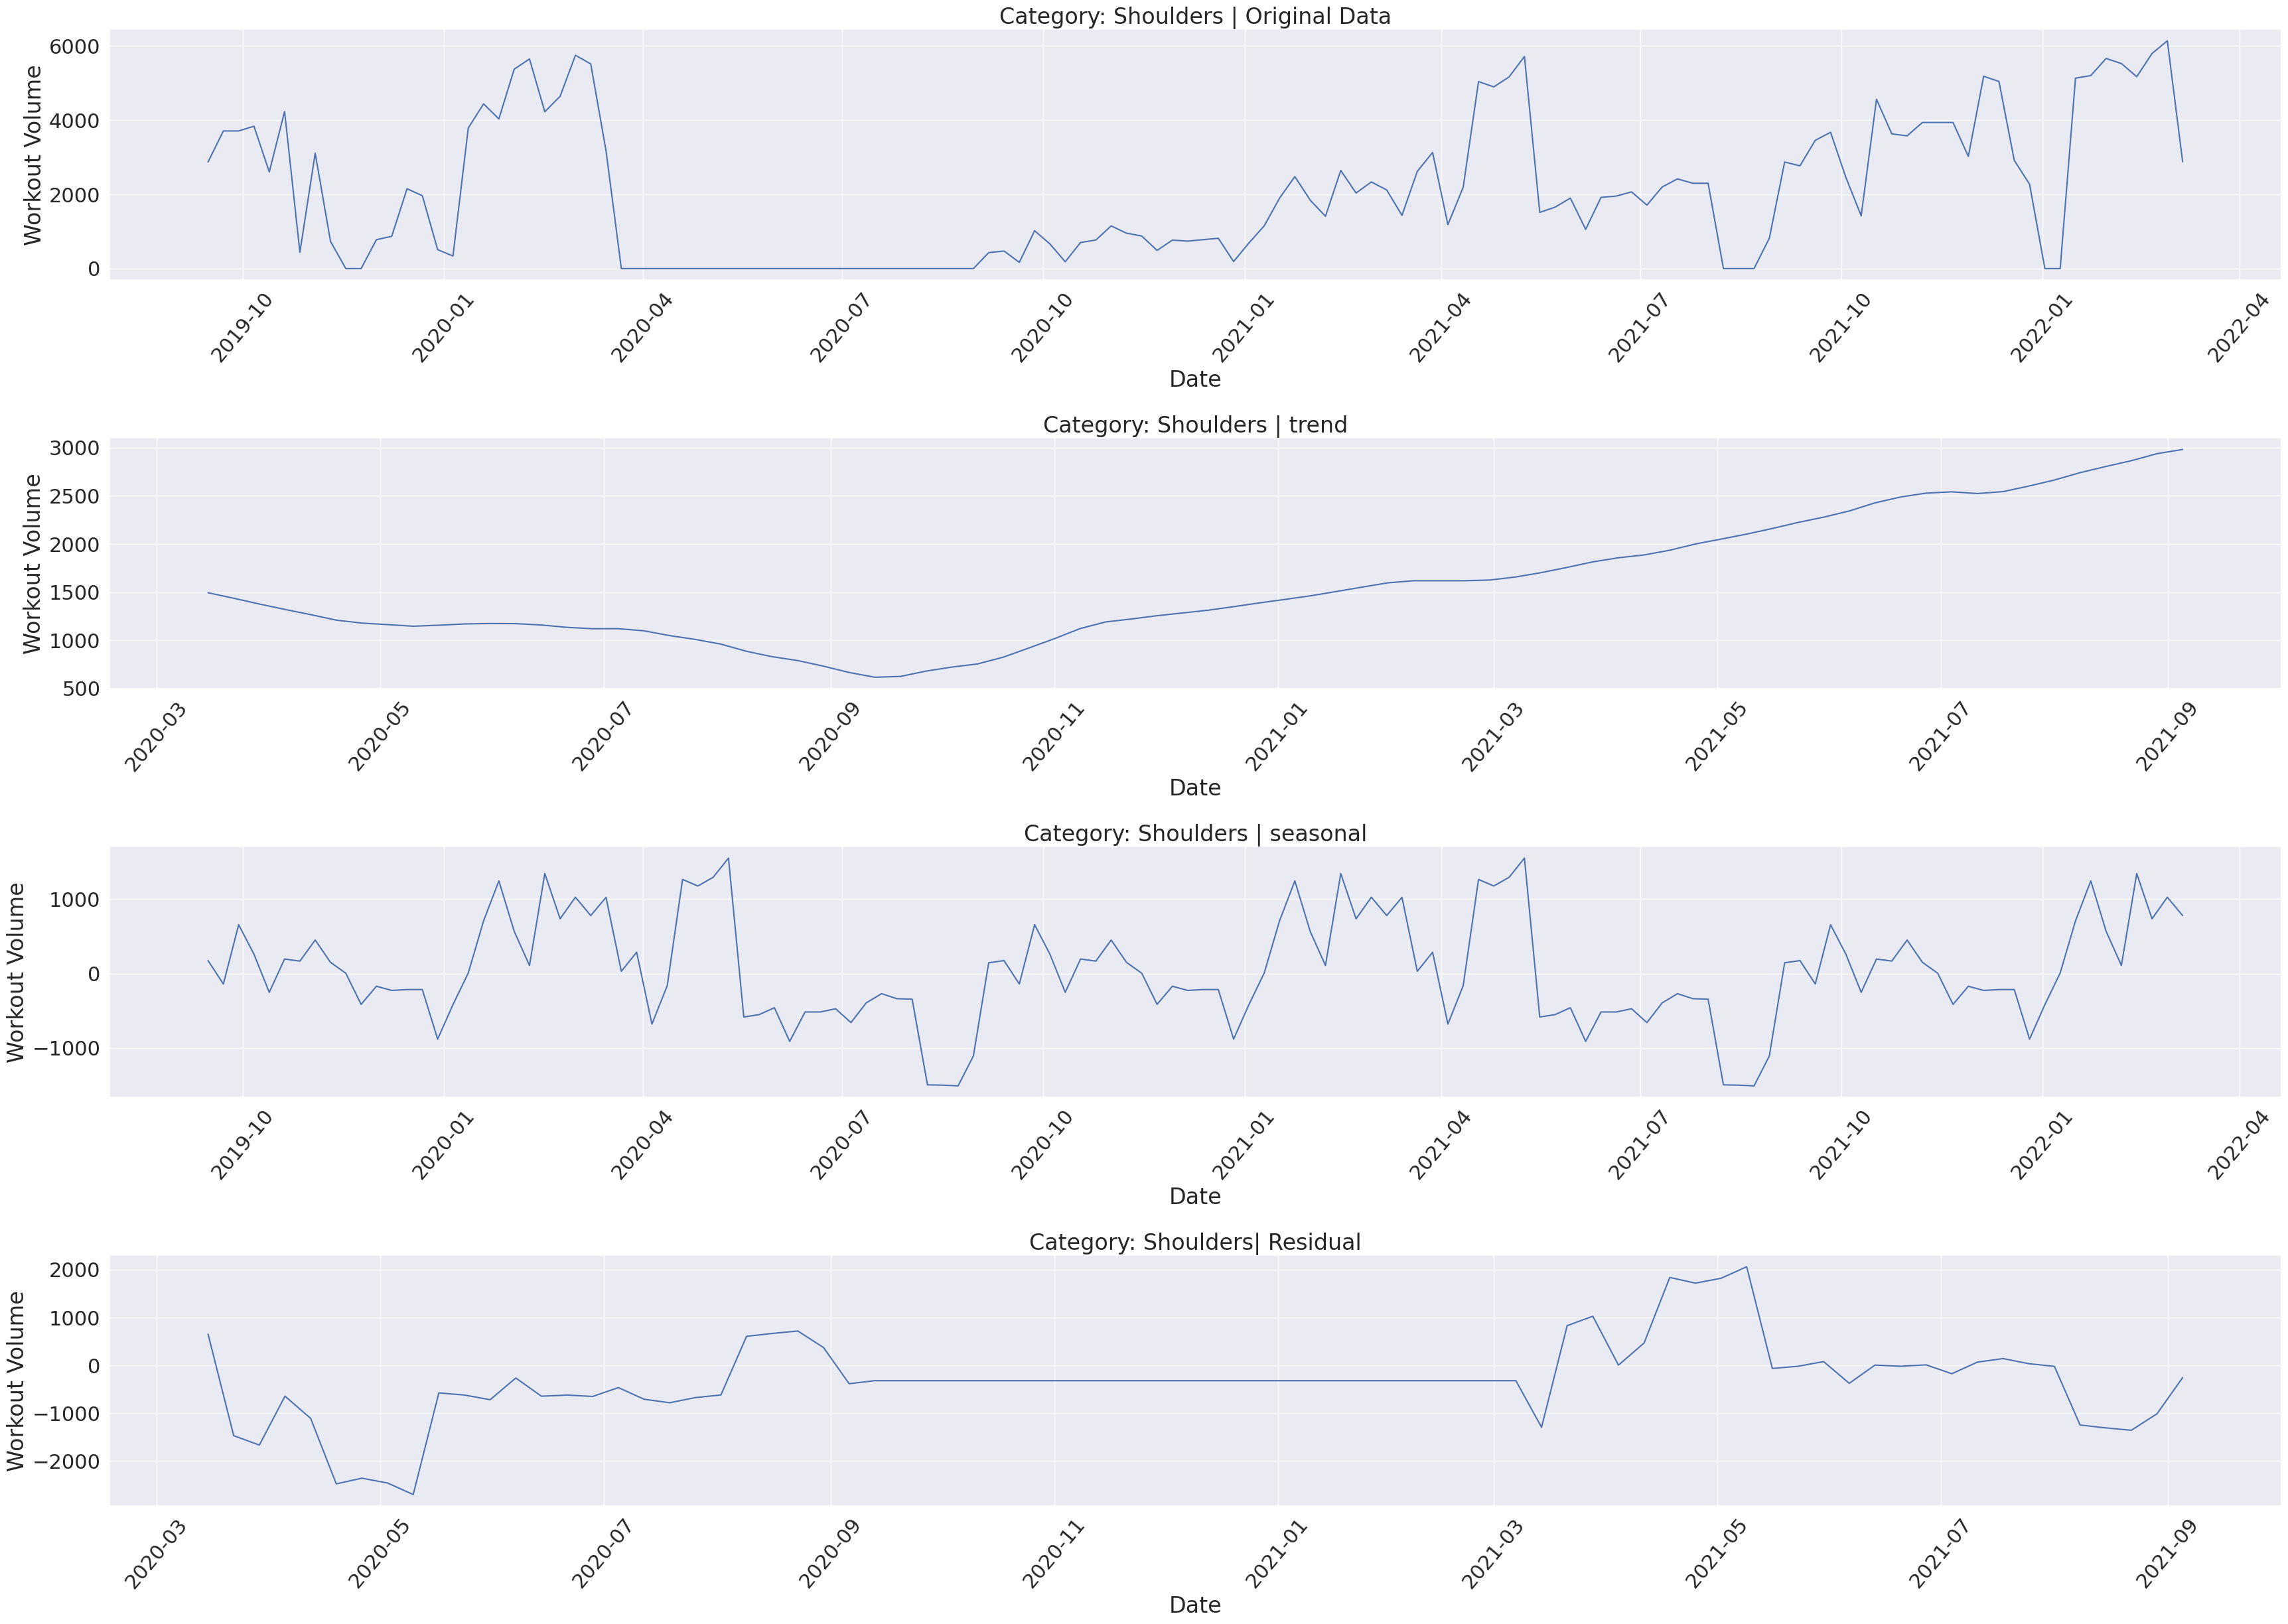

In [ ]:
# Shoulders
df = by_date_cat_resampled_sum.loc["Shoulders"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Shoulders | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Shoulders | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Shoulders | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Shoulders| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

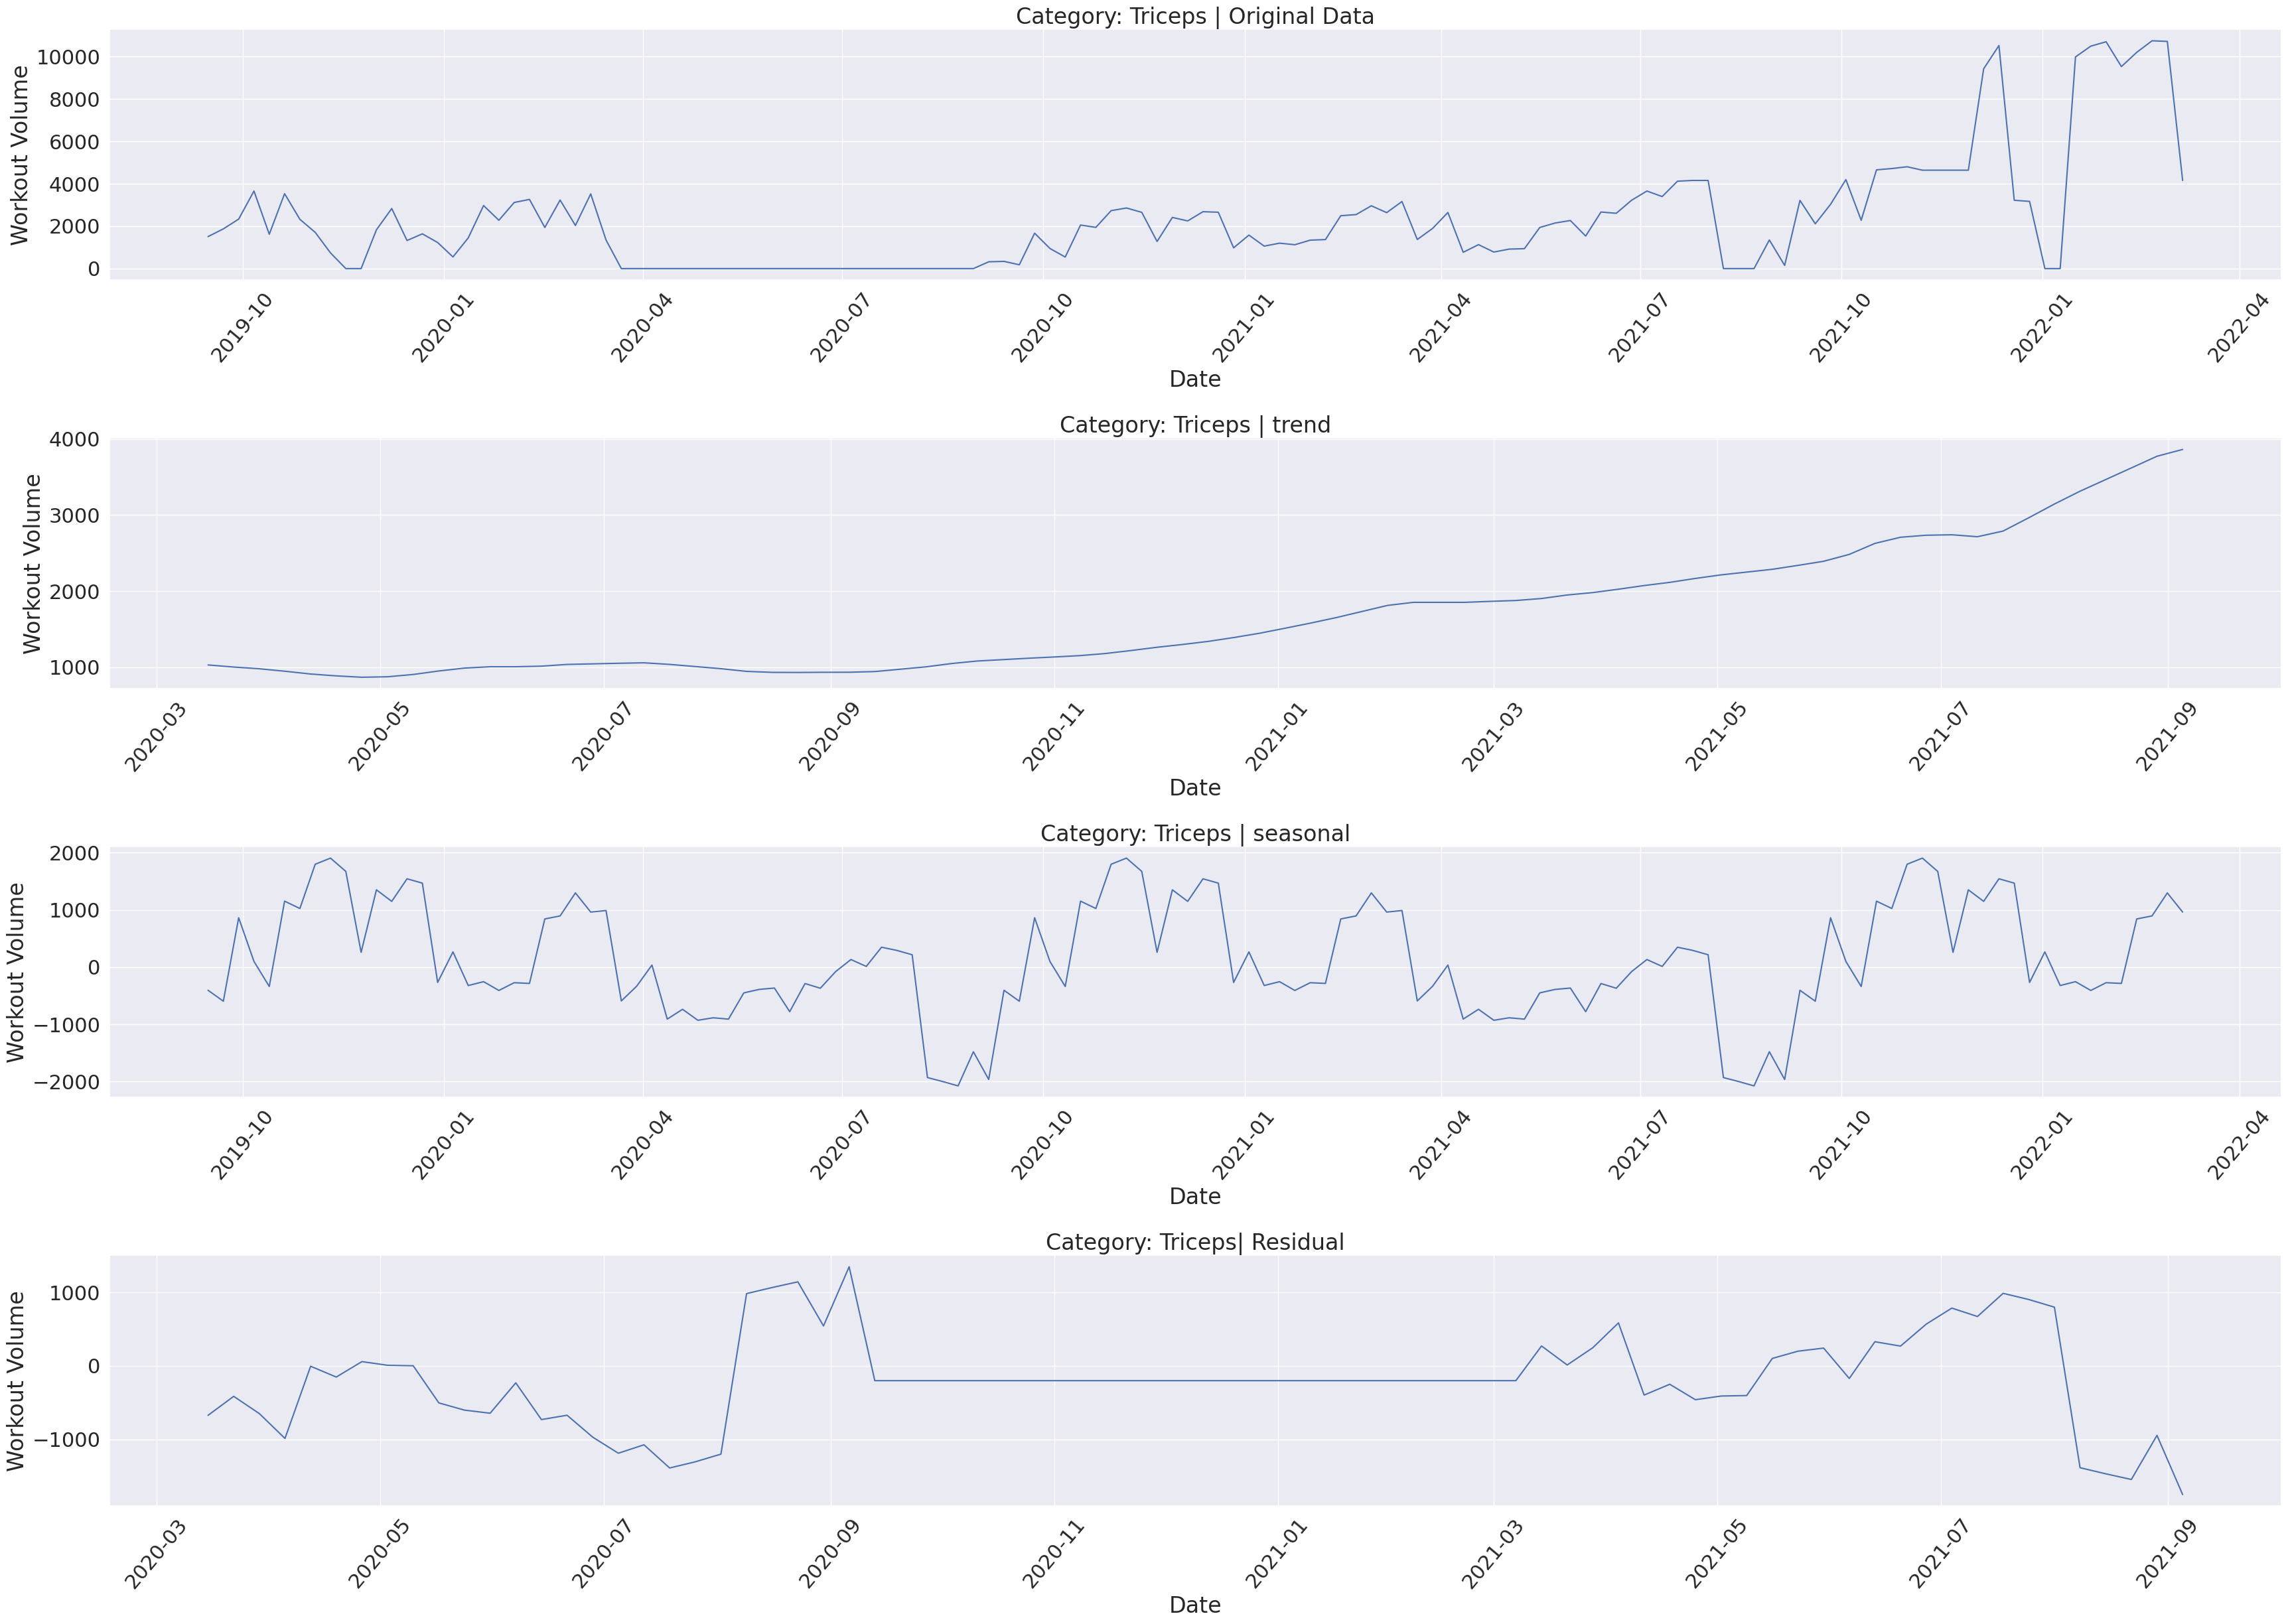

In [ ]:
# Triceps
df = by_date_cat_resampled_sum.loc["Triceps"]
decompose_result_mult = seasonal_decompose(df.Volume, model="additive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig, ax =  plt.subplots(4,1, figsize=(35,25), dpi=100)
ax[0].set_title('Category: Triceps | Original Data');
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Workout Volume")
ax[0].tick_params(axis="x", rotation=50)
ax[0].plot(df.reset_index().Date, df.Volume)



ax[1].set_title('Category: Triceps | trend');
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Workout Volume")
ax[1].tick_params(axis="x", rotation=50)
ax[1].plot(trend)

ax[2].set_title('Category: Triceps | seasonal');
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Workout Volume")
ax[2].tick_params(axis="x", rotation=50)
ax[2].plot(seasonal)

ax[3].set_title('Category: Triceps| Residual');
ax[3].set_xlabel("Date")
ax[3].set_ylabel("Workout Volume")
ax[3].tick_params(axis="x", rotation=50)
ax[3].plot(residual)


fig.tight_layout()

No handles with labels found to put in legend.


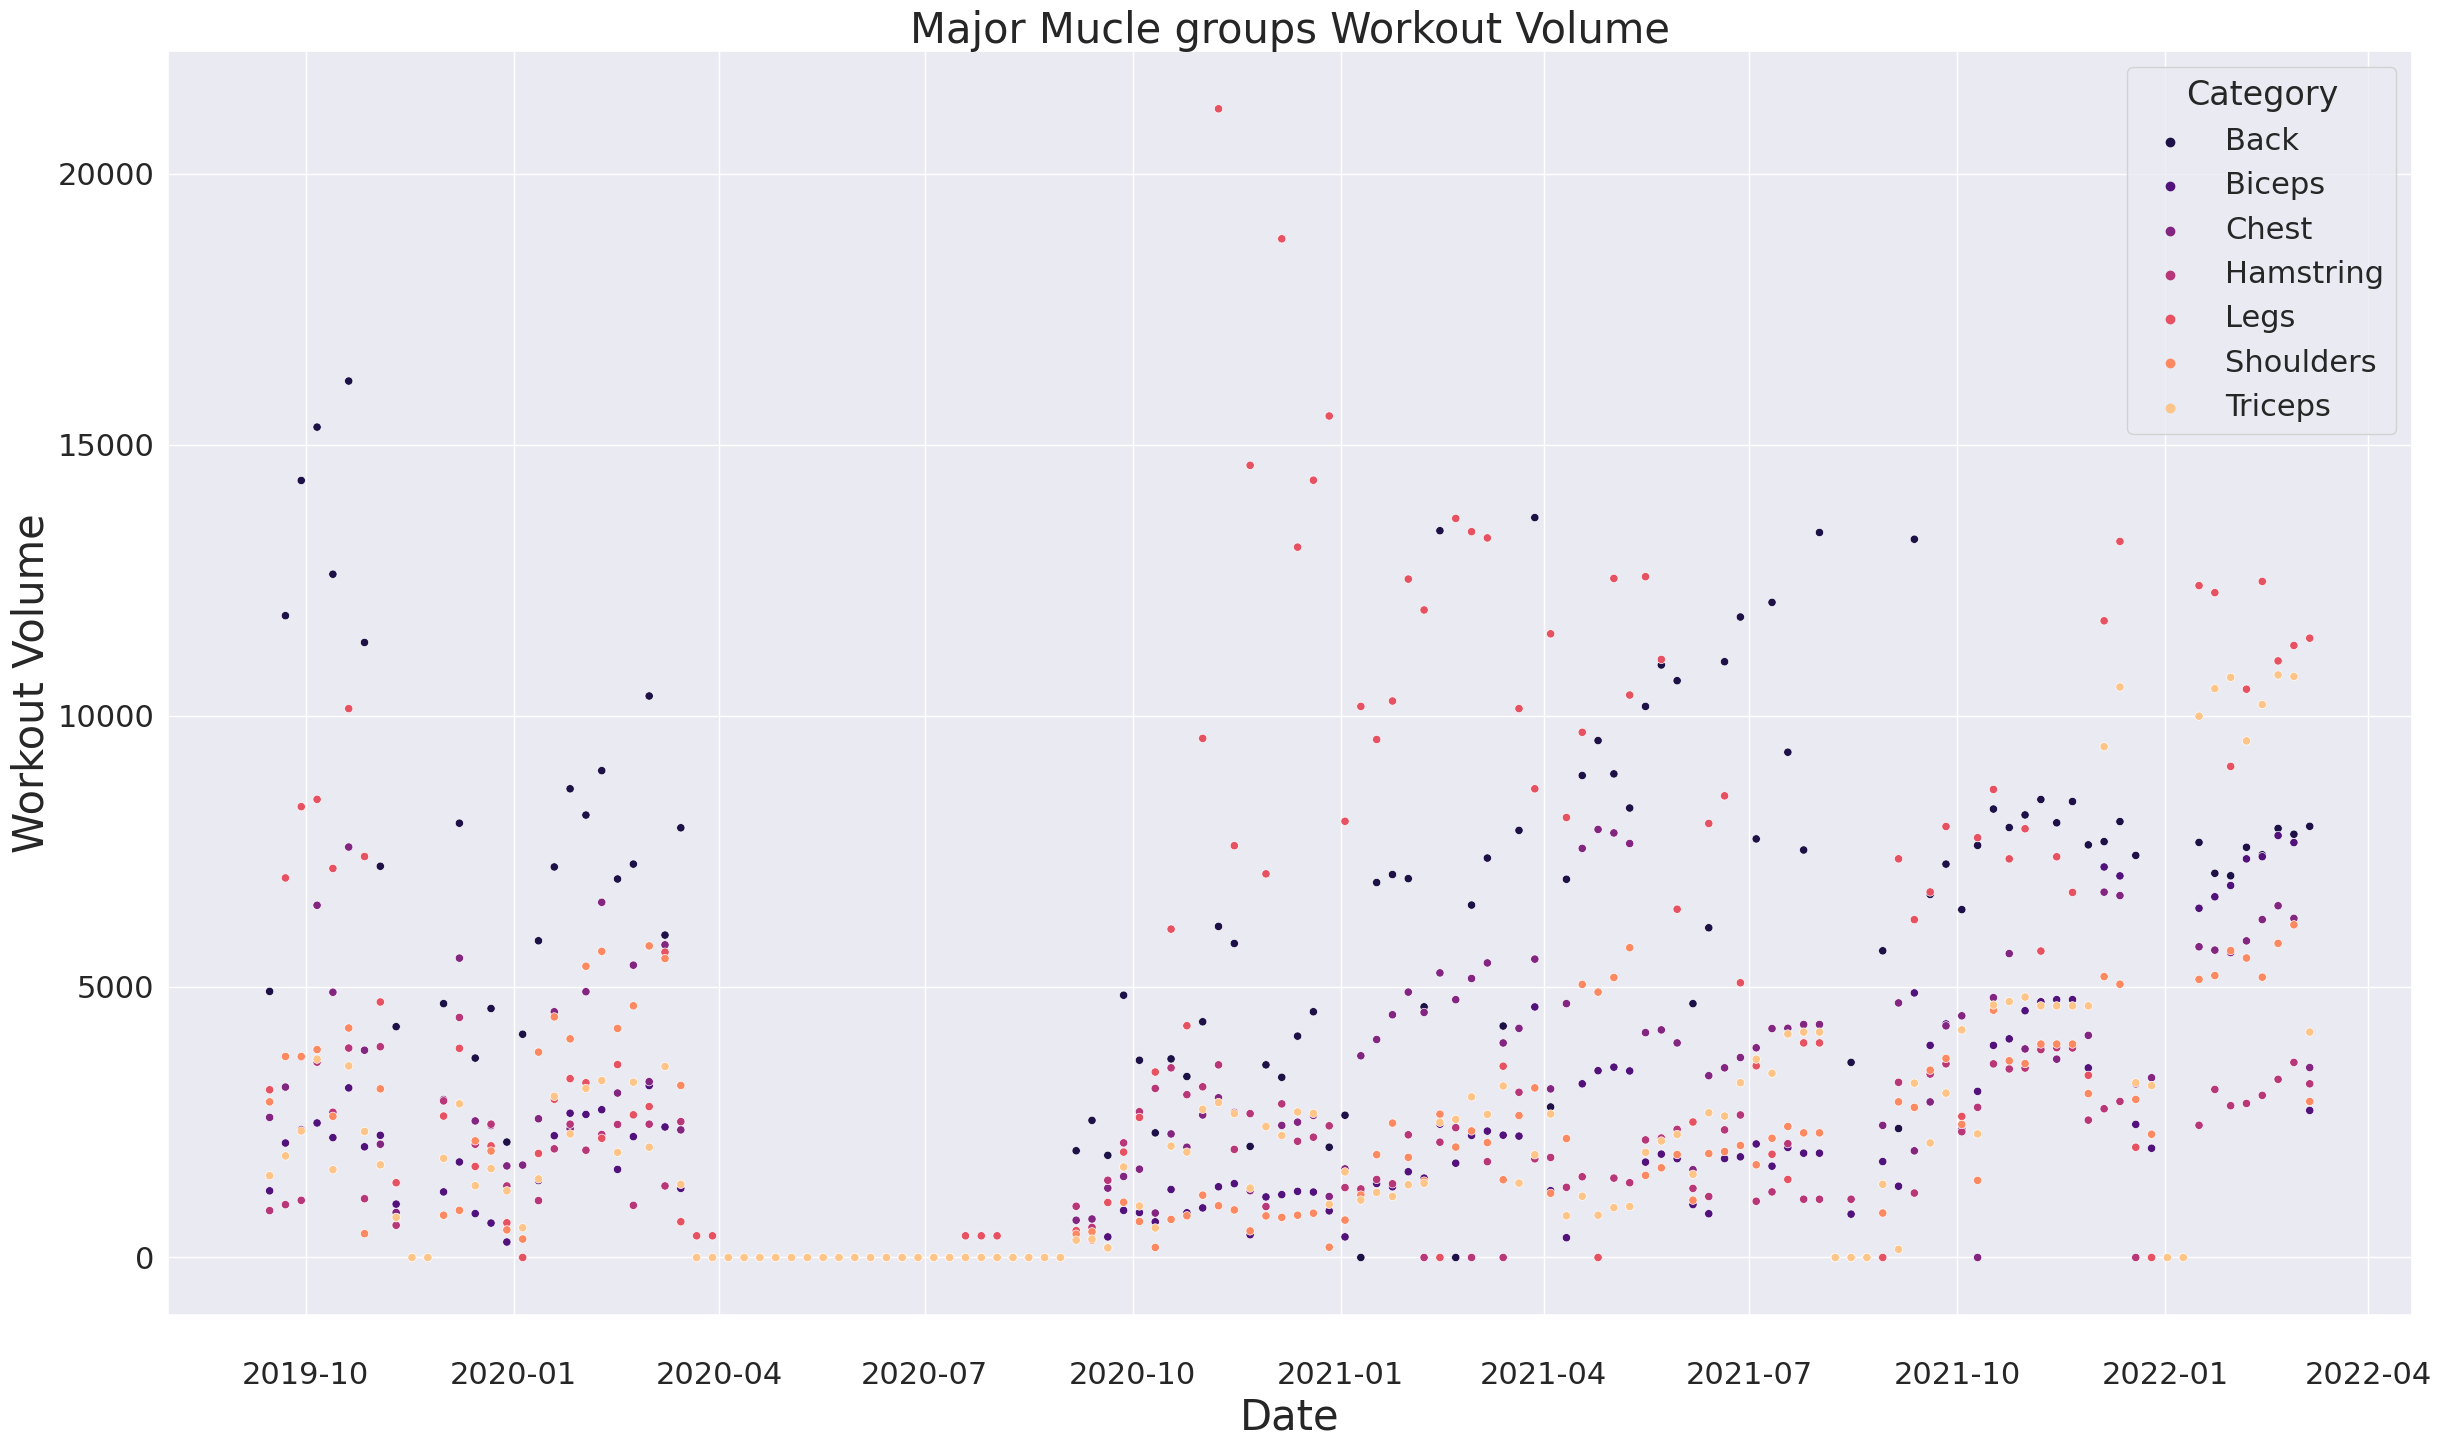

In [ ]:
musc = ['Back', 'Biceps','Chest','Hamstring', 'Legs', 'Shoulders', 'Triceps']
sample= by_date_cat_resampled_sum.loc[musc].reset_index()[["Date", "Category", "Volume"]]

fig, ax =  plt.subplots(1,1, figsize=(25,15), dpi=100)
ax.set_title('Major Mucle groups Workout Volume', fontsize=30);
ax.legend(loc='upper left', fontsize=20,bbox_to_anchor=(0, 1.1))
ax.set_xlabel("Date", fontsize=30)
ax.set_ylabel("Workout Volume", fontsize=30)
ax.tick_params(axis="x", rotation=0, size=30)
sns.scatterplot(sample.Date, sample.Volume, hue=sample.Category, palette="magma", ax=ax)
fig.tight_layout()

## Modeling

In [ ]:
data = by_date_cat_resampled_sum.loc[musc].reset_index().drop(["Distance", "Date"], axis=1)
data["Category"] = data["Category"].replace({_:index for index, _ in enumerate(data.Category.unique())})
data

Category  Weight   Reps   Volume  duration
0           0   415.0  211.0   4910.0       0.0
1           0  1125.0  371.0  11845.0       0.0
2           0  1200.0  417.0  14340.0       0.0
3           0  1355.0  328.0  15325.0       0.0
4           0  1170.0  223.0  12610.0       0.0
..        ...     ...    ...      ...       ...
905         6   699.0  207.0   9534.0       0.0
906         6   726.5  214.0  10205.0       0.0
907         6   731.0  222.0  10751.0       0.0
908         6   753.0  215.0  10723.0       0.0
909         6   208.0   80.0   4160.0       0.0

[910 rows x 5 columns]

In [ ]:
training_data = data.drop("Volume",axis=1)
X = training_data.values
y = data.Volume.values

### Pipeline


In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """
    Create a class to select numerical or categorical columns 
    since Scikit-Learn doesn't handle DataFrames yet.
    """
    def __init__(self, attribute_names): self.attribute_names = attribute_names

    def fit(self, X, y=None): return self

    def transform(self, X): 

        # from IPython.core.debugger import set_trace
        # set_trace()
        
        return X[self.attribute_names].values

class Estimatorstub(object):   
    """
    # Class to for proxy estimator.
    """
    
    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return self


# Identify the numeric features we wish to consider. 
num_attribs = ["Weight", "Reps"]
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ("scaling", StandardScaler())
    ])
# Identify the categorical features we wish to consider.
cat_attribs = ["Category"]
               

# Notice handle_unknown="ignore" in OHE which ignore values from the validation/test that
# do NOT occur in the training set
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
              
set_config(display="diagram")
data_prep_pipeline


FeatureUnion(transformer_list=[('num_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(attribute_names=['Weight',
                                                                                    'Reps'])),
                                                ('scaling',
                                                 StandardScaler())])),
                               ('cat_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(attribute_names=['Category'])),
                                                ('ohe',
                                                 OneHotEncoder(handle_unknown='ignore',
                                                               sparse=False))]))])

#### Baseline Model

In [ ]:
%%time 
np.random.seed(42)

max_training_size = int(data.shape[0] * 0.6)
max_test_size = int(data.shape[0] * 0.25)
splits = TimeSeriesSplit(n_splits=3, gap=2, max_train_size=max_training_size, test_size=max_test_size)


rmse = []
mse = []
mae = []
mape = []

for train_index, test_index in splits.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = pd.DataFrame(X_train, columns=training_data.columns), pd.DataFrame(X_test, columns=training_data.columns)
    print("New Split------->")
    print("Original Data:%d" % (len(data)))
    print('Total Observations: %d' % (len(X_train) + len(X_test)))
    print('Training Observations: %d' % (len(X_train)))
    print('Testing Observations: %d' % (len(X_test)))

    full_pipeline_with_predictor = Pipeline([
            ("preparation", data_prep_pipeline),
            ("linear", LinearRegression())
        ])
    model = full_pipeline_with_predictor.fit(X_train, y_train)

    mse_model = np.round(mean_squared_error(y_test, model.predict(X_test)), 3)
    rmse_model = np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test))), 3)
    mae_model = np.round(mean_absolute_error(y_test, model.predict(X_test)), 3)
    mape_model = np.round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 3)
    print(mape_model)
    rmse.append(rmse_model)
    mae.append(mae_model   )
    mape.append(mape_model)
    mse.append(mse_model)

print("Average model scores:")
print("MSE:", np.round(np.average(mse), 3))
print("RMSE:", np.round(np.average(rmse), 3))
print("MAE:", np.round(np.average(mae), 3))
print("MAPE:",np.round(np.average(mape), 3))

New Split------->
Original Data:910
Total Observations: 454
Training Observations: 227
Testing Observations: 227
1.558555083238114e+17


New Split------->
Original Data:910
Total Observations: 681
Training Observations: 454
Testing Observations: 227
9.964760383490299e+16


New Split------->
Original Data:910
Total Observations: 773
Training Observations: 546
Testing Observations: 227
9.793864651886459e+16


Average model scores:
MSE: 912110.817
RMSE: 893.989
MAE: 515.02
MAPE: 1.1781391955919298e+17
CPU times: user 96.5 ms, sys: 692 µs, total: 97.2 ms
Wall time: 248 ms


##### Baseline Model| Results

```
Average model scores:
MSE: 912110.817
RMSE: 893.989
MAE: 515.02
MAPE: 1.1781391955919298e+17
```

#### Gridsearch and hyperparamter tunning

In [ ]:
rmse = []
mse = []
mae = []
mape = []
evs = []
best_model = None
best_score = 9999999999

debugging=False

for train_index, test_index in splits.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = pd.DataFrame(X_train, columns=training_data.columns), pd.DataFrame(X_test, columns=training_data.columns)
    if debugging:
        print("New Split------->")
        print("Original Data:%d" % (len(data)))
        print('Total Observations: %d' % (len(X_train) + len(X_test)))
        print('Training Observations: %d' % (len(X_train)))
        print('Testing Observations: %d' % (len(X_test)))

    full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("clf", Estimatorstub()),
    ])

    param_grid = [
        {
            "preparation__num_pipeline__scaling": [
                'passthrough', 
                Normalizer(norm="max"), 
                Normalizer(norm="l2"),
                Normalizer(norm="l1"),
                StandardScaler()
            ],
            'clf': (LinearRegression(),),
        },
        {
        "preparation__num_pipeline__scaling": [
            'passthrough', 
            Normalizer(norm="max"), 
            Normalizer(norm="l2"),
            Normalizer(norm="l1"),
            StandardScaler()
        ],
        'clf': (Ridge(),),
        "clf__solver": ["sag", "saga"],
        "clf__alpha": [1, 10, 20, 30, 50, 100]
        },
        {
        "preparation__num_pipeline__scaling": [
            'passthrough', 
            Normalizer(norm="max"), 
            Normalizer(norm="l2"),
            Normalizer(norm="l1"),
            StandardScaler()
        ],
        'clf': (Lasso(),),
        "clf__alpha": [1, 10, 20, 30, 50, 100]
        },
        {
        "preparation__num_pipeline__scaling": [
            'passthrough', 
            Normalizer(norm="max"), 
            Normalizer(norm="l2"),
            Normalizer(norm="l1"),
            StandardScaler()
        ],
        'clf': (ElasticNet(),),
        "clf__alpha": [1, 10, 20, 30, 50, 100],
        "clf__l1_ratio": [0.1, 0.25, 0.4, 0.5, 0.65, 0.75, 0.9]
        },
        {
        "preparation__num_pipeline__scaling": [
            'passthrough', 
            Normalizer(norm="max"), 
            Normalizer(norm="l2"),
            Normalizer(norm="l1"),
            StandardScaler()
        ],
        'clf': (SGDRegressor(),),
        "clf__alpha": [1, 10, 20, 30, 50, 100],
        "clf__l1_ratio": [0.1, 0.25, 0.4, 0.5, 0.65, 0.75, 0.9],
        "clf__penalty": ["l1", "l2", "elasticnet"],
        },
    ]
    # RandomizedSearchCV
    gsv = GridSearchCV(
        full_pipeline_with_predictor, param_grid, 
        cv=2, n_jobs=-1, verbose=2, return_train_score=True, scoring="neg_mean_squared_error"
    )
    model = gsv.fit(X_train, y_train)
    model_score = -1* model.best_score_
    if model_score< best_score:
        best_score = model_score
        best_model = model
    if debugging:
        print("The best mean squred error is: {}".format(-1* model.best_score_))
        print("The best parameters for current split is: {}".format(model.best_params_))
        print("\n\nGrid search Results:-----")


    mse_model = np.round(mean_squared_error(y_test, model.predict(X_test)), 3)
    rmse_model = np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test))), 3)
    mae_model = np.round(mean_absolute_error(y_test, model.predict(X_test)), 3)
    mape_model = np.round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 3)
    evs_model = np.round(explained_variance_score(y_test, model.predict(X_test)), 3)
    evs.append(evs_model)
    rmse.append(rmse_model)
    mae.append(mae_model)
    mape.append(mape_model)
    mse.append(mse_model)
    
print()
print()
print("*_-+-_*"*10)
print("Average model scores:")
print("MSE:", np.round(np.average(mse), 3))
print("RMSE:", np.round(np.average(rmse), 3))
print("MAE:", np.round(np.average(mae), 3))
print("MAPE:",np.round(np.average(mape), 3))
print("Explained Variance Score", np.round(np.average(evs), 3))
print("The best parameters for model are", best_model.best_params_)
print("*_-+-_*"*50)

Fitting 2 folds for each of 935 candidates, totalling 1870 fits
Fitting 2 folds for each of 935 candidates, totalling 1870 fits
Fitting 2 folds for each of 935 candidates, totalling 1870 fits
*_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_*
Average model scores:
MSE: 912144.806
RMSE: 894.018
MAE: 514.736
MAPE: 1.1306224850851e+17
Explained Variance Score 0.913
The best parameters for model are {'clf': LinearRegression(), 'preparation__num_pipeline__scaling': StandardScaler()}
*_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_**_-+-_*

## Pytorch

In [ ]:
from torchsummary import summary  
import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
dtype = torch.cuda.FloatTensor
torch.manual_seed(0)

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device
    # return torch.device('cpu')

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df).float().to(device)

def wrapper_roc_auc_score(y_pred_tensor, y_test_tensor):
    y_true = y_test_tensor.cpu().detach().numpy()
    y_pred = y_pred_tensor.cpu().detach().numpy()
    return roc_auc_score(y_true, y_pred)

In [ ]:
%%time 
sample_x_train_agg = X_train
sample_x_valid_agg = X_test
sample_x_test_agg = pd.DataFrame(training_data.values[:np.min(train_index)], columns=training_data.columns)
sample_y_train = y_train
sample_y_valid = y_test
sample_y_test = y[:np.min(train_index)]


sample_x_train = data_prep_pipeline.fit_transform(sample_x_train_agg)
sample_x_valid = data_prep_pipeline.transform(sample_x_valid_agg)
sample_x_test = data_prep_pipeline.transform(sample_x_test_agg)


# convert numpy arrays to tensors
X_train_tensor = df_to_tensor(sample_x_train)
X_validation_tensor = df_to_tensor(sample_x_valid)
X_test_tensor = df_to_tensor(sample_x_test)
y_train_tensor = df_to_tensor(sample_y_train)
y_validation_tensor = df_to_tensor(sample_y_valid)
y_test_tensor = df_to_tensor(sample_y_test)


# create TensorDataset in PyTorch
eadm_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
eadm_validation = torch.utils.data.TensorDataset(X_validation_tensor, y_validation_tensor)
eadm_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# create dataloader
trainloader_eadm = torch.utils.data.DataLoader(eadm_train, batch_size=sample_x_train.shape[0], shuffle=True, num_workers=0)
validloader_eadm = torch.utils.data.DataLoader(eadm_validation, batch_size=sample_x_valid.shape[0], shuffle=False, num_workers=0)
testloader_eadm = torch.utils.data.DataLoader(eadm_test, batch_size=sample_x_test.shape[0], shuffle=False, num_workers=0)

D_in = X_train_tensor.shape[1]

print(D_in)

CPU times: user 15.3 ms, sys: 16 µs, total: 15.3 ms
Wall time: 15.6 ms


In [ ]:
class BaseRegression(nn.Module):
    """Custom module for binary classifier"""
    def __init__(self, in_features, hidden=5, n_output=1):
        super(BaseRegression, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden)   # hidden layer
        self.fc2 = torch.nn.Linear(hidden, out_features=n_output)
  
    def forward(self, x):
        # activation function for hidden layer   
        x = F.relu(self.fc1(x))        
        x = self.fc2(x) 
        return x  



model = BaseRegression(in_features=D_in)
loss_fn = torch.nn.MSELoss(reduction='mean') 
optimizer = optim.SGD(model.parameters(), lr=0.00001)
device = get_device()
print(f"Computation device: {device}\n")
model.to(device)

print('-'*50)
print('Model:')
print(model)
print('-'*50)


epochs = range(1000)
for epoch in epochs:
    running_loss = 0.0
    count = 0
    for batch, data in enumerate(trainloader_eadm):
        inputs, target = data[0].to(device), data[1].to(device)
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        # do forward pass
        output = model(inputs.float())
        # compute loss and gradients
        loss = loss_fn(output, target.reshape(output.shape[0],1))
        # get gradients w.r.t to parameters
        loss.backward()
        # perform gradient update
        optimizer.step()
        # loss
        running_loss += loss.item()
        count += 1
    if (epoch%50)==0:
        print(f"Epoch {epoch},Train MSE loss: {np.round(running_loss/count, 3)}")

print('Finished Training')
print('-'*50)

running_loss = 0.0
count = 0
for batch, data in enumerate(validloader_eadm):
    inputs, target = data[0].to(device), data[1].to(device)
    # do forward pass
    output = model(inputs.float())

    # compute loss and gradients
    loss = loss_fn(output, target.reshape(output.shape[0],1))
    output = model(inputs.float())
    
    running_loss += loss.item()
    count += 1

print(f" Validation MSE loss: {np.round(running_loss/count, 3)}")

running_loss = 0.0
count = 0
for batch, data in enumerate(testloader_eadm):
    inputs, target = data[0].to(device), data[1].to(device)
    # do forward pass
    output = model(inputs.float())

    # compute loss and gradients
    loss = loss_fn(output, target.reshape(output.shape[0],1))
    
    output = model(inputs.float())
    running_loss += loss.item()
    count += 1
    
print(f" TEST MSE loss: {np.round(running_loss/count, 3)}")

Computation device: cpu

--------------------------------------------------
Model:
BaseRegression(
  (fc1): Linear(in_features=7, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)
--------------------------------------------------
Epoch 0,Train MSE loss: 19256650.0
Epoch 50,Train MSE loss: 12704590.0
Epoch 100,Train MSE loss: 833351.125
Epoch 150,Train MSE loss: 727181.438
Epoch 200,Train MSE loss: 698212.312
Epoch 250,Train MSE loss: 683598.312
Epoch 300,Train MSE loss: 674557.688
Epoch 350,Train MSE loss: 668667.438
Epoch 400,Train MSE loss: 664688.125
Epoch 450,Train MSE loss: 662101.375
Epoch 500,Train MSE loss: 660412.438
Epoch 550,Train MSE loss: 659297.562
Epoch 600,Train MSE loss: 658555.938
Epoch 650,Train MSE loss: 658059.375
Epoch 700,Train MSE loss: 657724.625
Epoch 750,Train MSE loss: 657498.188
Epoch 800,Train MSE loss: 657344.125
Epoch 850,Train MSE loss: 657238.375
Epoch 900,Train MSE loss: 657165.625
Epoch 950,Train MSE loss: 657115

## Pytroch | MSE : 754921 